How To Serve As Slides:

    jupyter nbconvert path/to/notebook --to slides --post serve


# Liberating tabular data from the clutches of PDFs      
         
          
           
            
    
**By: Jayant Pahuja & Spongebob   
Data Expert @OpenBudgetsIndia    
Core Team Member @DataKindBlR**

## Budgets 

- Why are budgets important ?
- What kind of data is published ?
- How are they published ?


## What does a budget Document look like ?


In [245]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, HTML
import pandas as pd
import numpy as np
import pdb

### 150+ Budget Source Websites

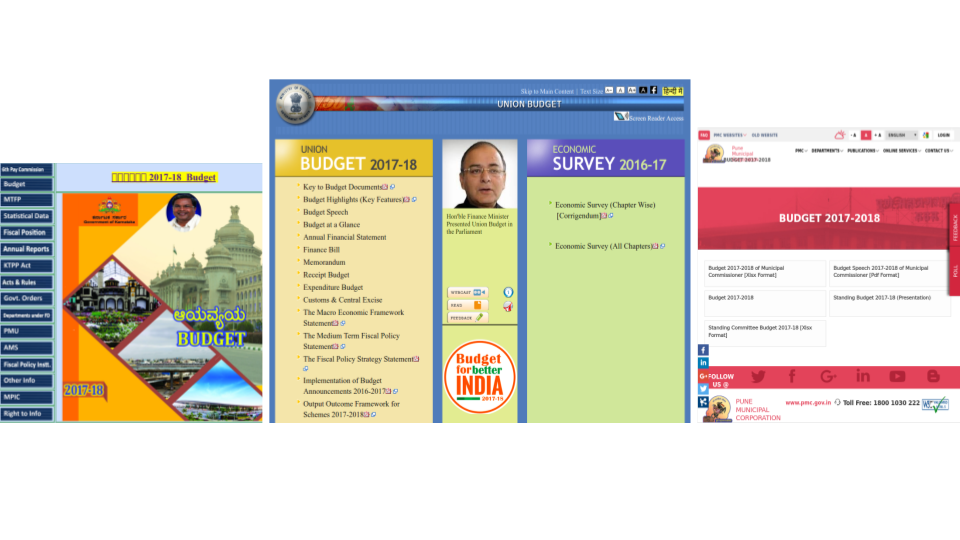

In [246]:
Image('govt_budget_portals.png')

## Problems with Budget Documents 

- Unstructured PDF documents
- Inconsistent Formats
- Budgets published in local languages


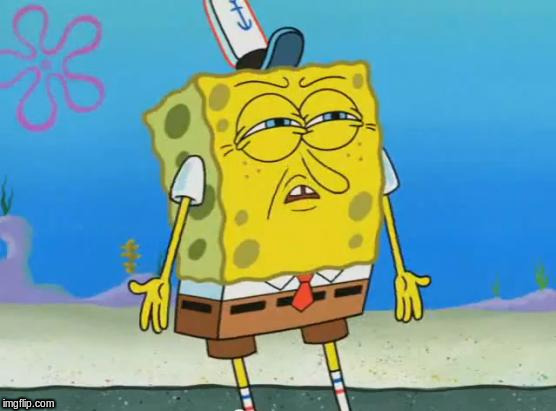

In [247]:
Image('whaat.jpg')

## Karnataka Budget

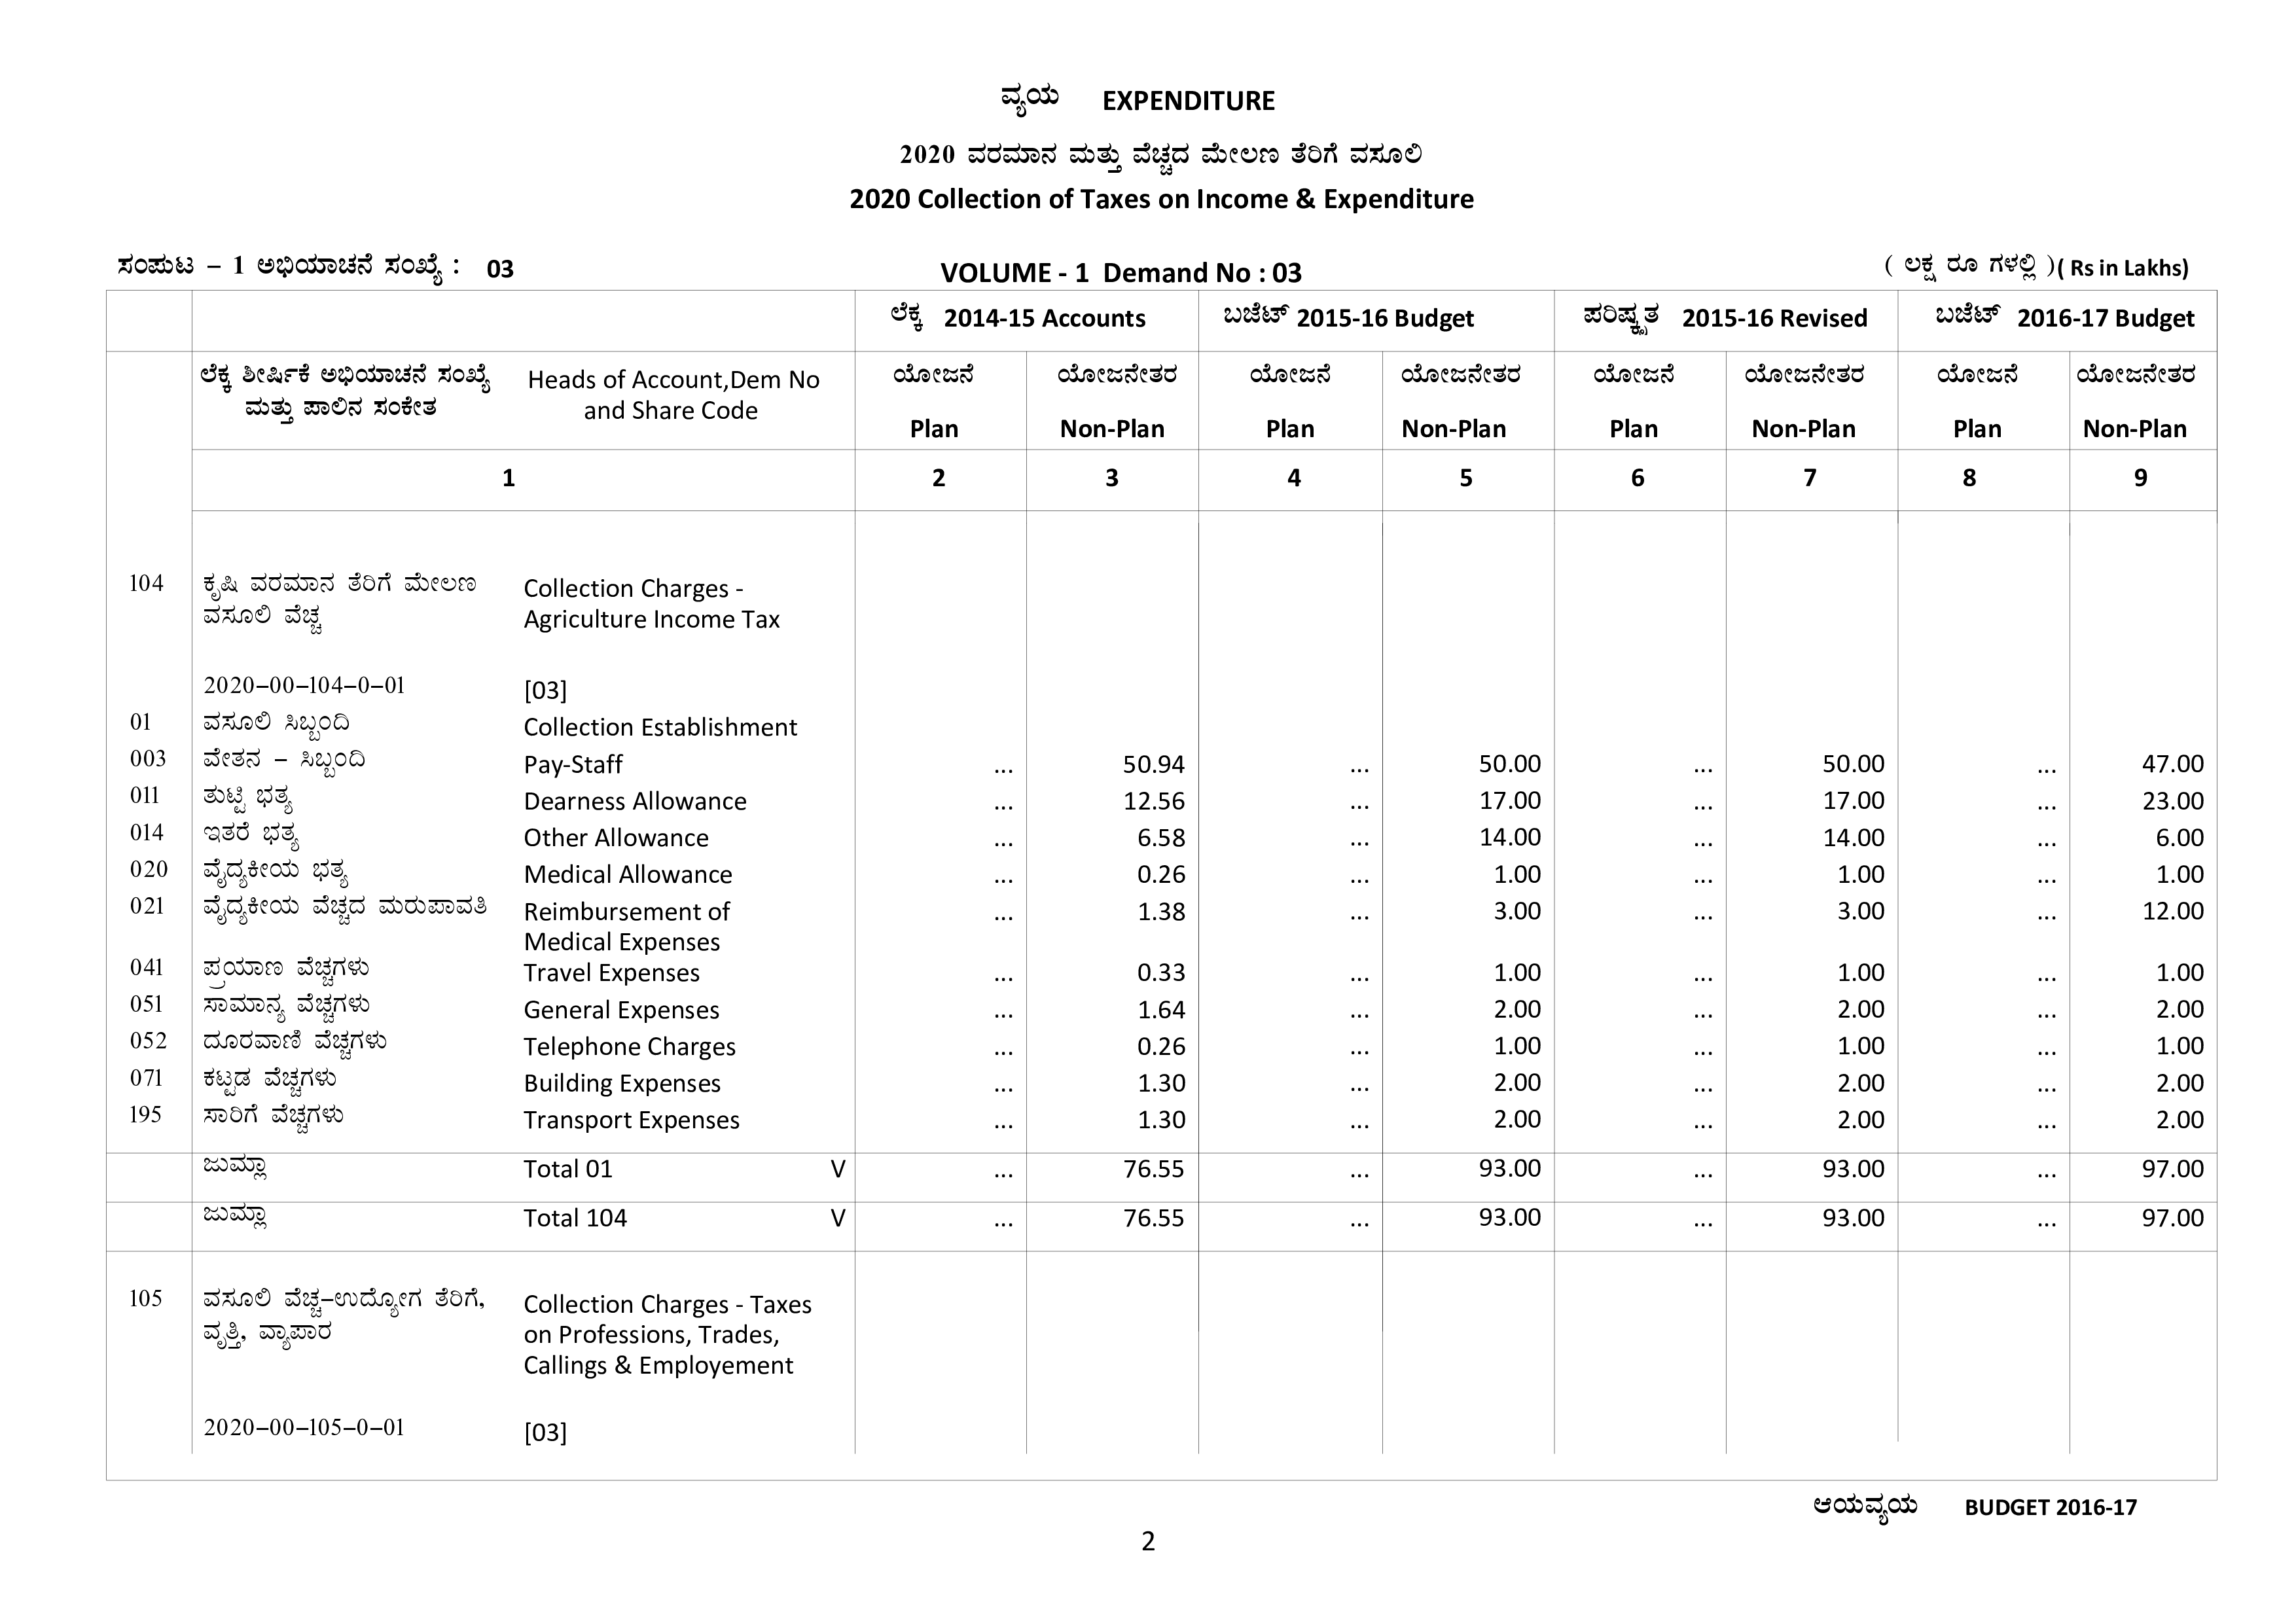

In [23]:
Image('kn_sample_image.png')

## West Bengal Budget

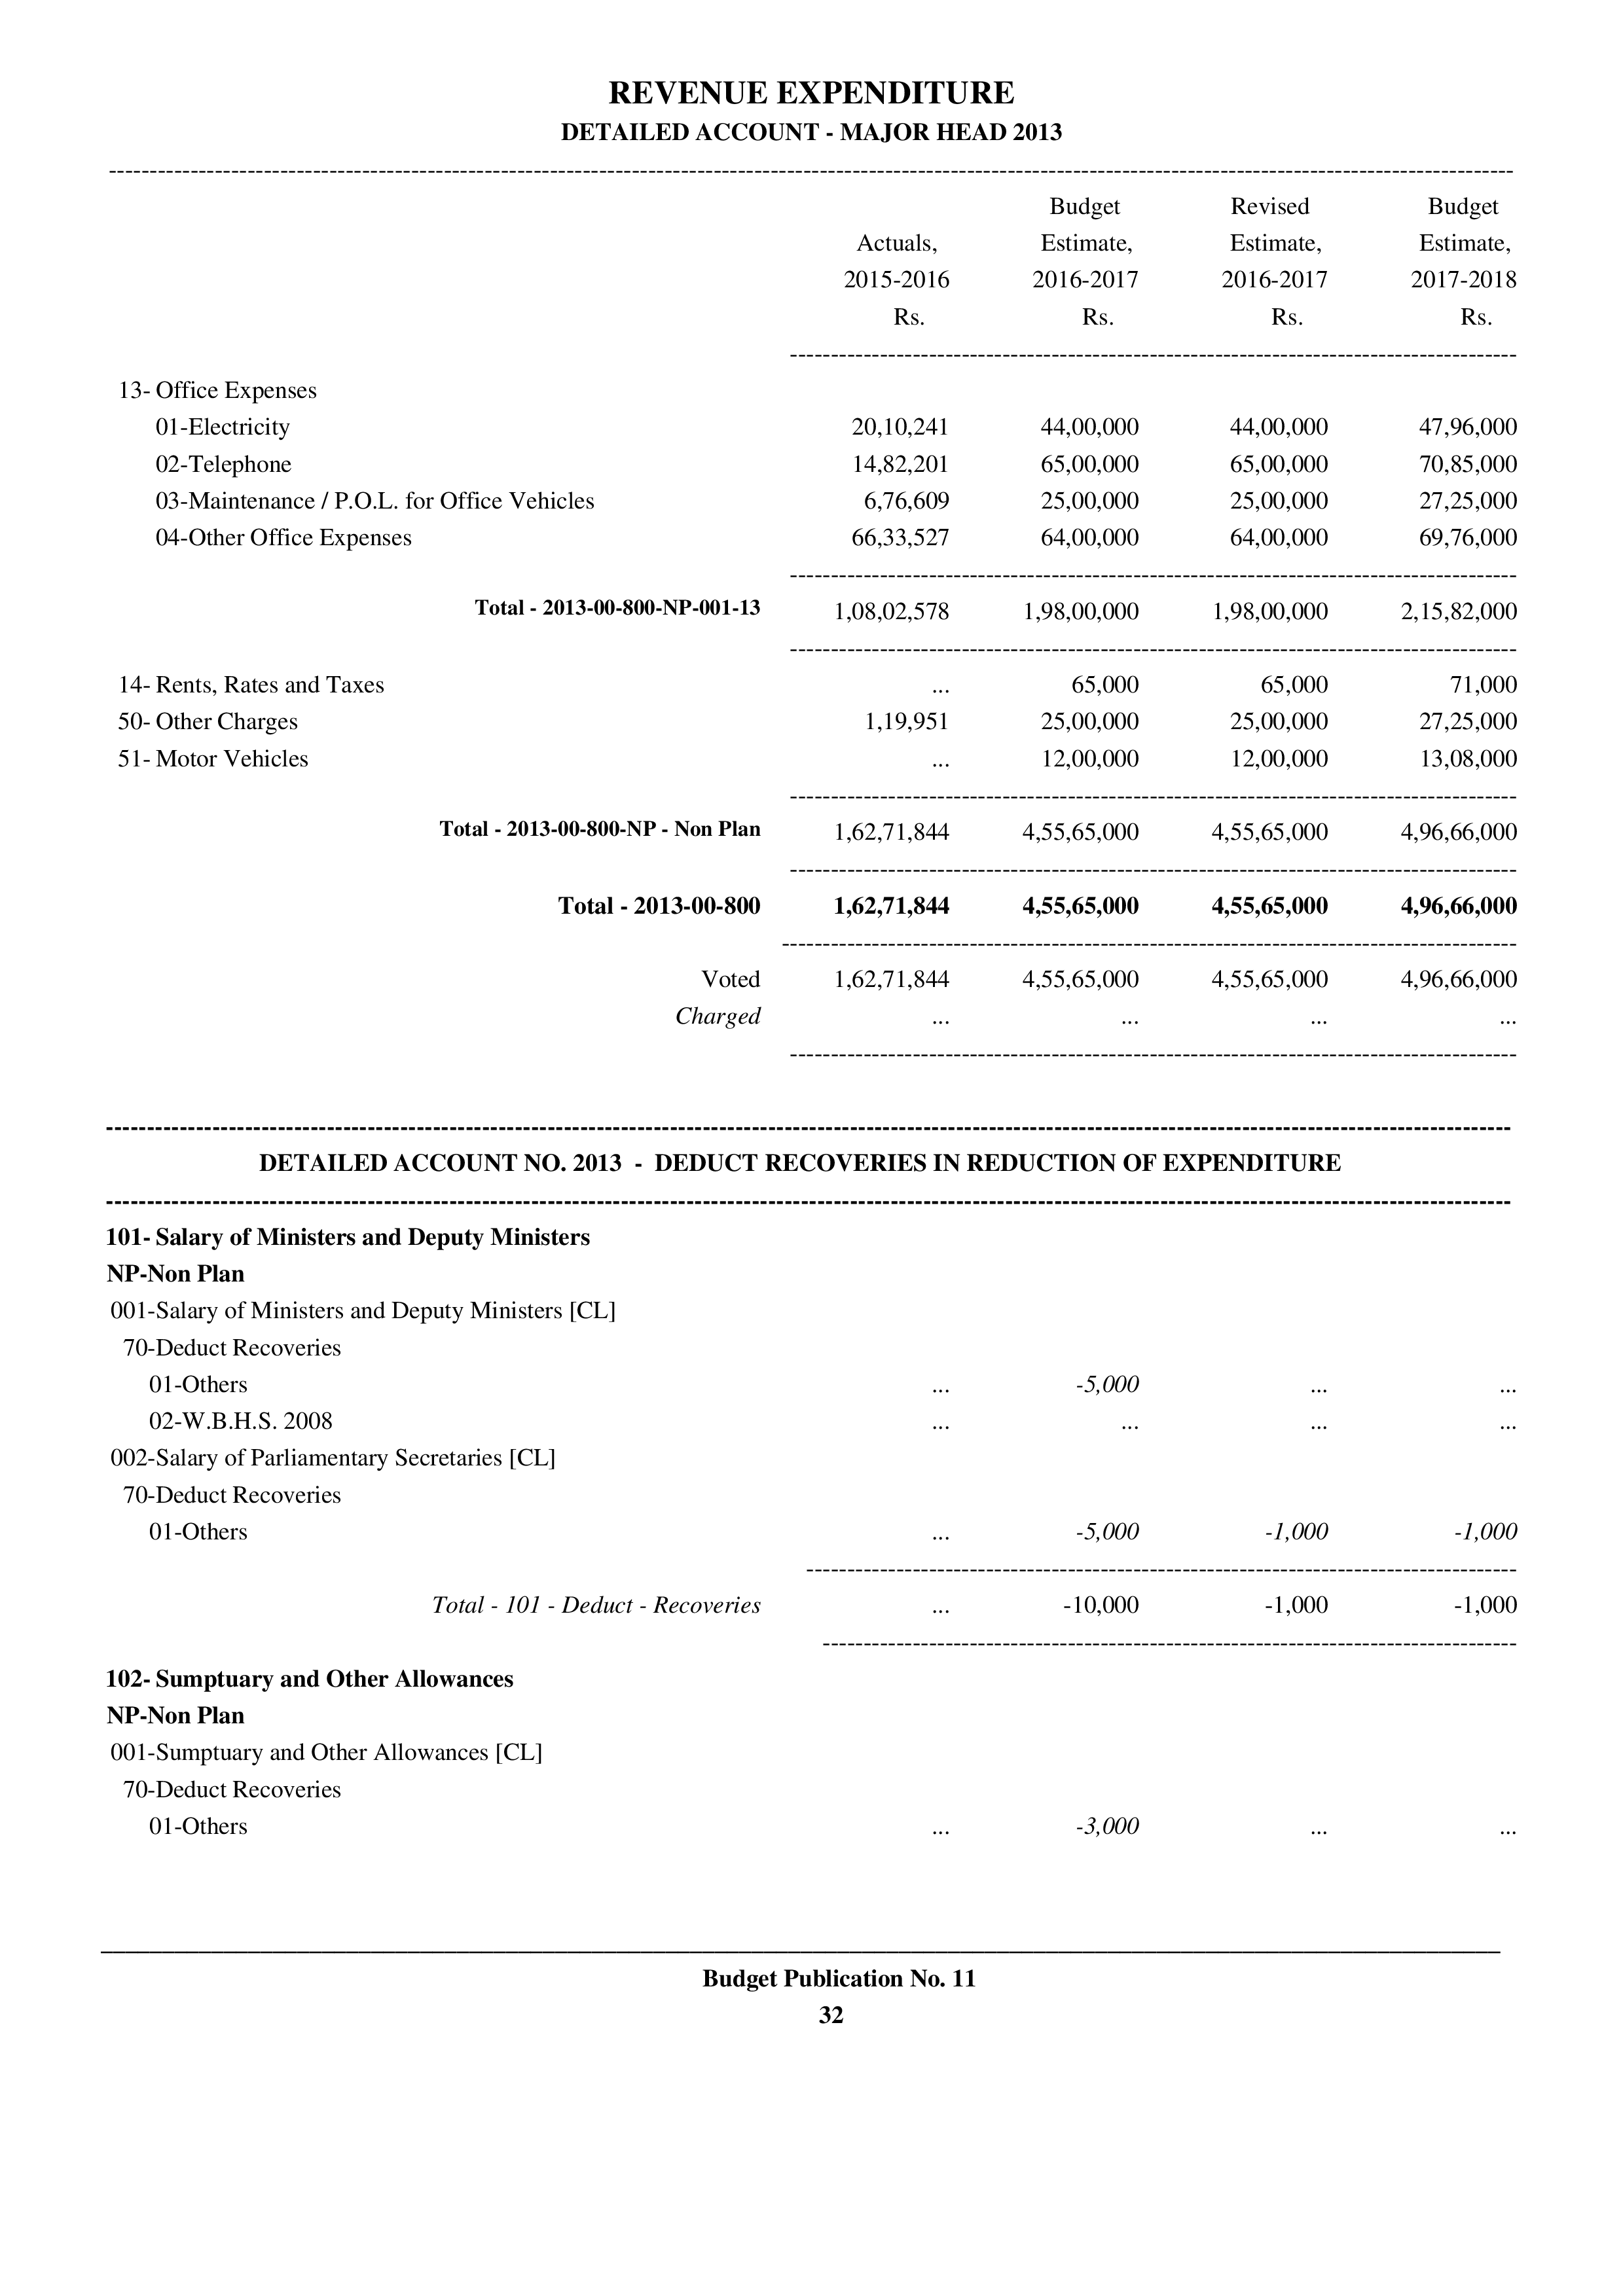

In [170]:
Image('west_bengal_sample.png')

## Gujarat Budget

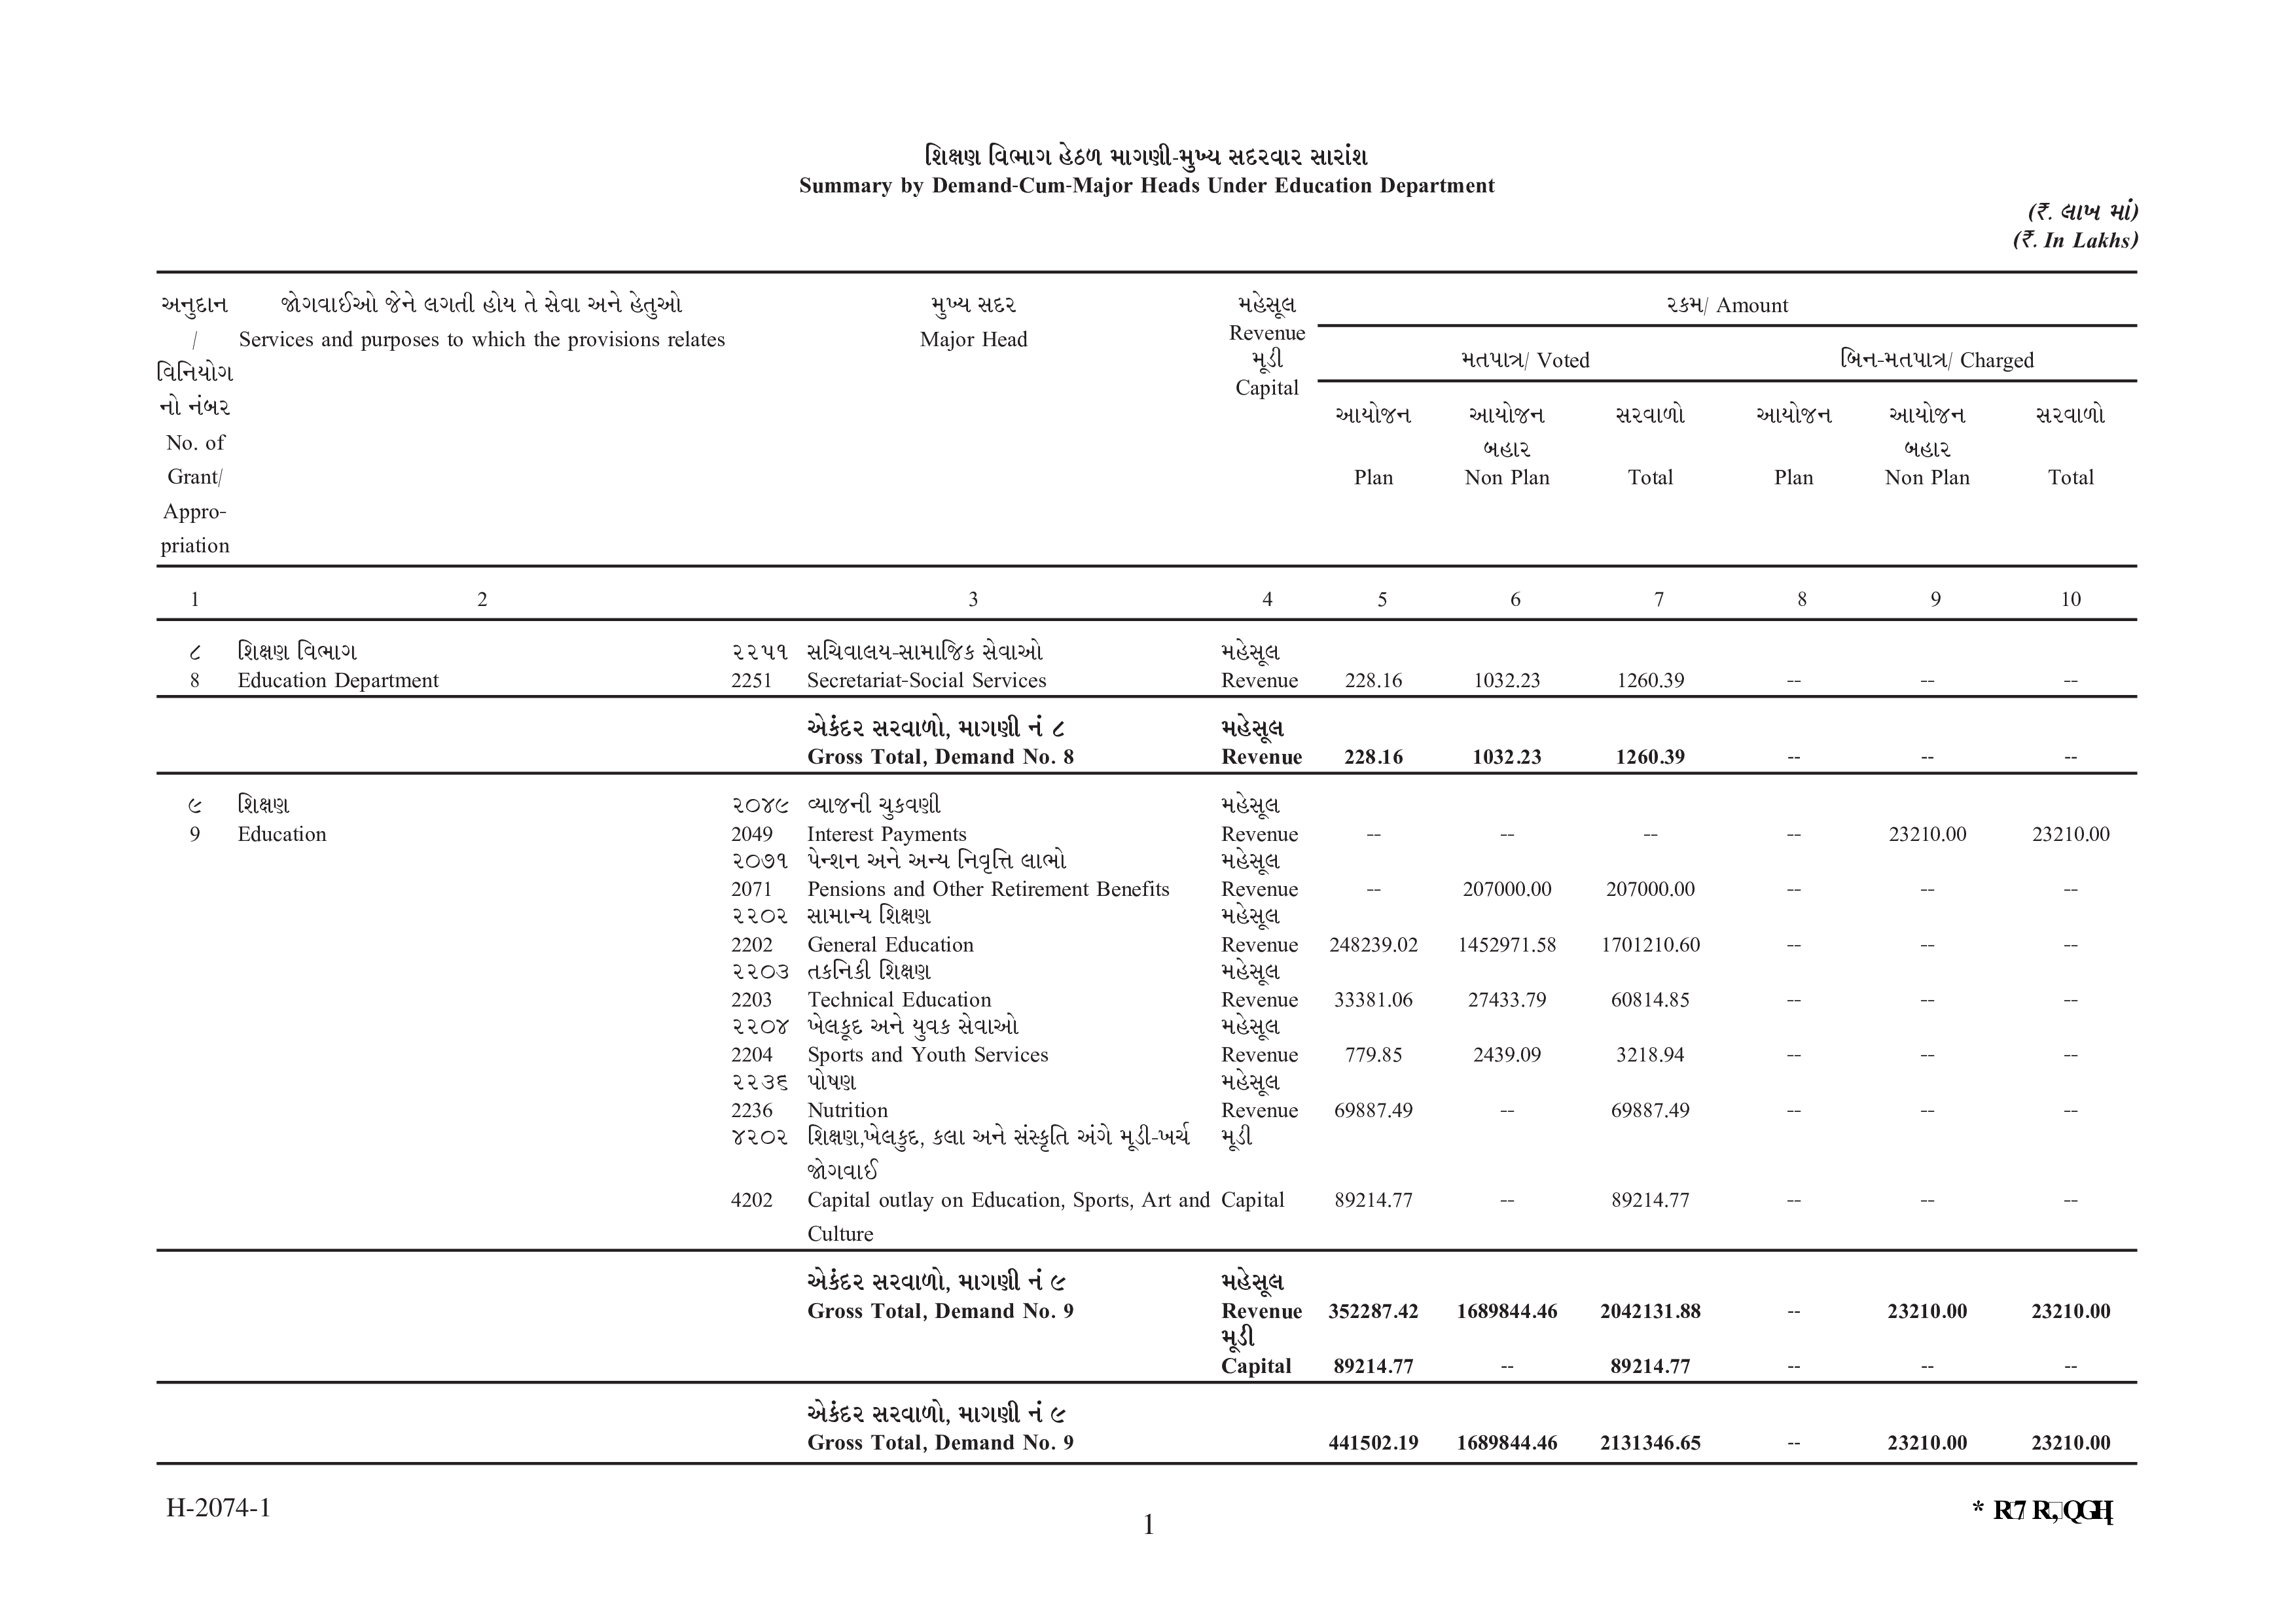

In [171]:
Image('gj_sample_image.png')

In [172]:
from PyPDF2 import PdfFileReader

# Reading a pdf file
kn_pdf_file_path = 'pdfs/karnataka/Volume-01.pdf'
kn_pdf = PdfFileReader(open(kn_pdf_file_path, 'rb'))

# Reading a pdf file
gj_pdf_file_path = 'pdfs/gujarat/4.-education.pdf'
gj_pdf = PdfFileReader(open(kn_pdf_file_path, 'rb'))

## Categories of Budget Documents

### Documents with Table Boundaries
- Karnataka Budget Documents

### Documents without Table Boundaries
- West Bengal
- Gujarat

## Extracting Tables From Documents with Table Boundaries

**Concept**: Detect Rows and Columns based on the lines detected and parse the infromation to extract tables in csv format. 

- Detect Lines
    - Vertical
    - Horizontal
- Detect Table Boundaries
- Parse Tables To extract information in csv format.

## Converting Pdf Page To Image - I

In [239]:
import cv2
import subprocess

# Converting a pdf page into an Image for processing
def get_page_image_from_pdf(page_num, image_file_name, pdf_file_path):
    '''
    Convert a pdf page into an image using imagemagick's convert utility 
    '''
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)

## Converting Pdf Page To Image - II

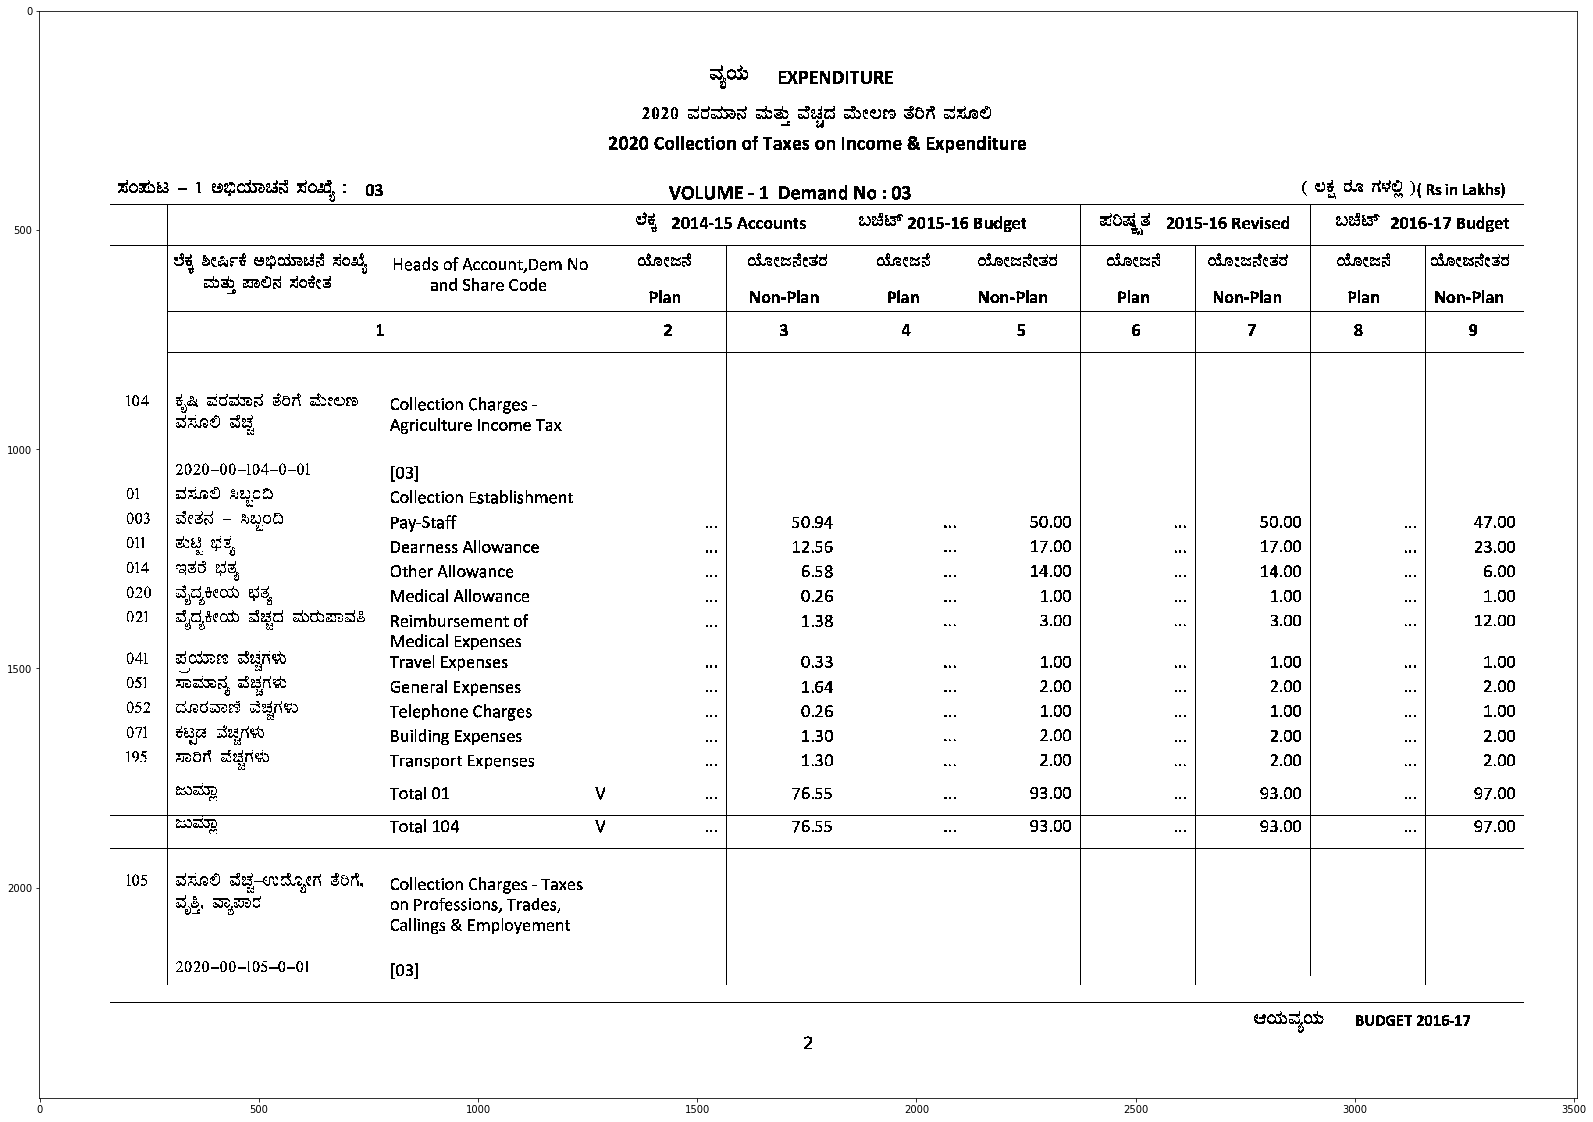

In [99]:
kn_page_image = get_page_image_from_pdf(11, 'kn_sample_image.png', kn_pdf_file_path)
plt.figure(figsize=(30,20))
plt.imshow(kn_page_image, cmap='gray')

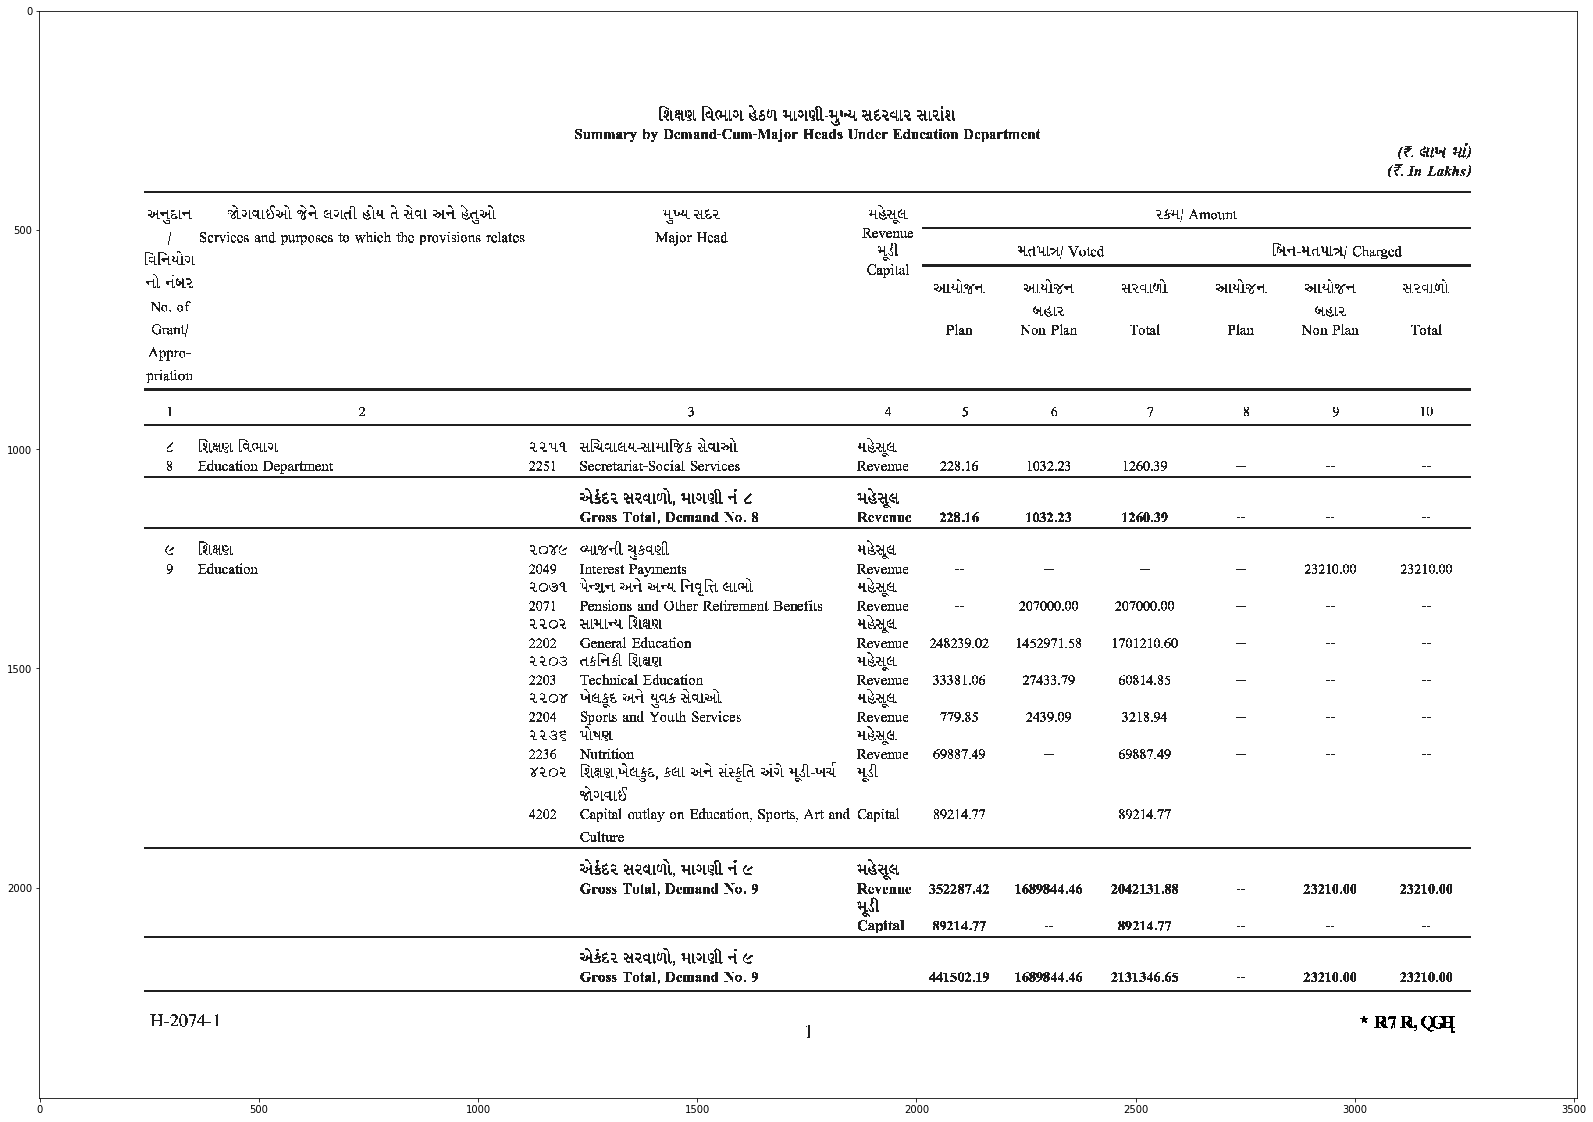

In [7]:
gj_page_image = get_page_image_from_pdf(4, 'gj_sample_image.png', gj_pdf_file_path)
plt.figure(figsize=(30,20))
plt.imshow(gj_page_image, cmap='gray')

## West Bengal Budget Document

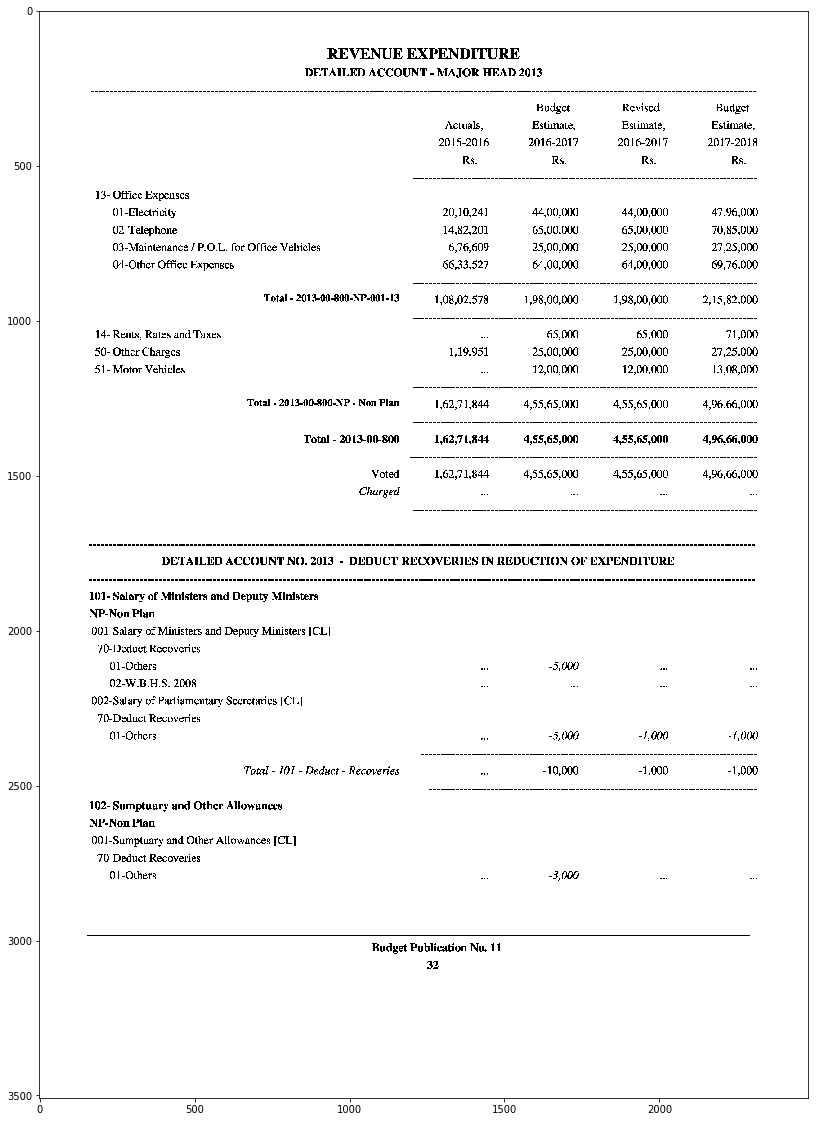

In [8]:
# Similarly we can read other documents and convert to images for processing
wb_pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'
wb_pdf = PdfFileReader(open(wb_pdf_file_path, 'rb'))

wb_page_image = get_page_image_from_pdf(33, 'west_bengal_sample.png', wb_pdf_file_path)

plt.figure(figsize=(30,20))
plt.imshow(wb_page_image, cmap='gray')

### Detecting Lines

To detect lines we use openCV's Hough Transform Implementation

    cv2.HoughLines(), cv2.HoughLinesP()


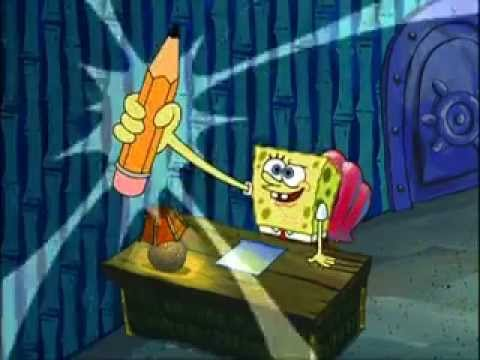

In [248]:
Image('lines.jpg')

In [174]:
def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')


def plot_lines_on_image(lines, img):
    canvas = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(canvas,(x1,y1),(x2,y2),(255,0,255),10)
    plot_page(canvas)

## Extracting Edges

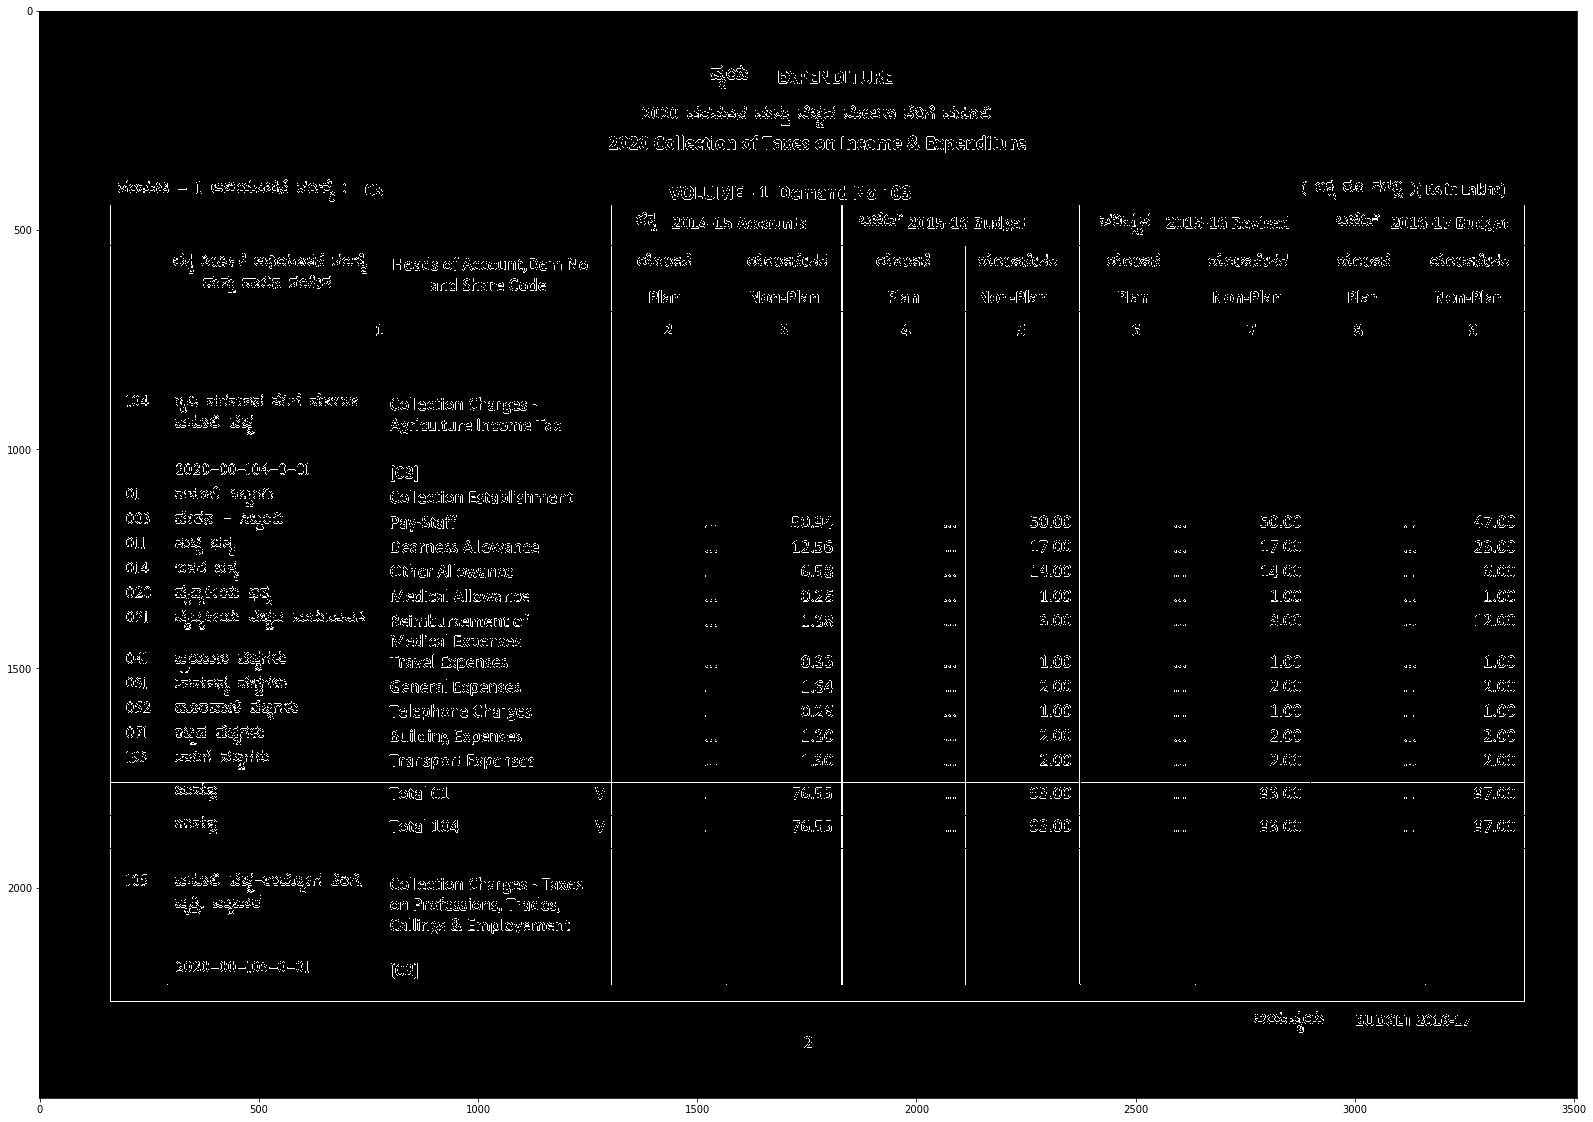

In [179]:
edges = cv2.Canny(kn_page_image, 120, 150, apertureSize=3)
plot_page(edges)

## Detecting Lines From Edges - Hough Transform

In [187]:
lines = cv2.HoughLines(edges,1,np.pi/180,200)
lines[:5]

array([[[  4.42000000e+02,   1.57079637e+00]],

       [[  2.26000000e+03,   1.57079637e+00]],

       [[  5.35000000e+02,   1.57079637e+00]],

       [[  1.76000000e+03,   1.57079637e+00]],

       [[  1.83500000e+03,   1.57079637e+00]]], dtype=float32)

In [184]:
HTML('<img src="http://opencv-python-tutroals.readthedocs.io/en/latest/_images/houghlinesdemo.gif">')

## Detecting Straight Lines

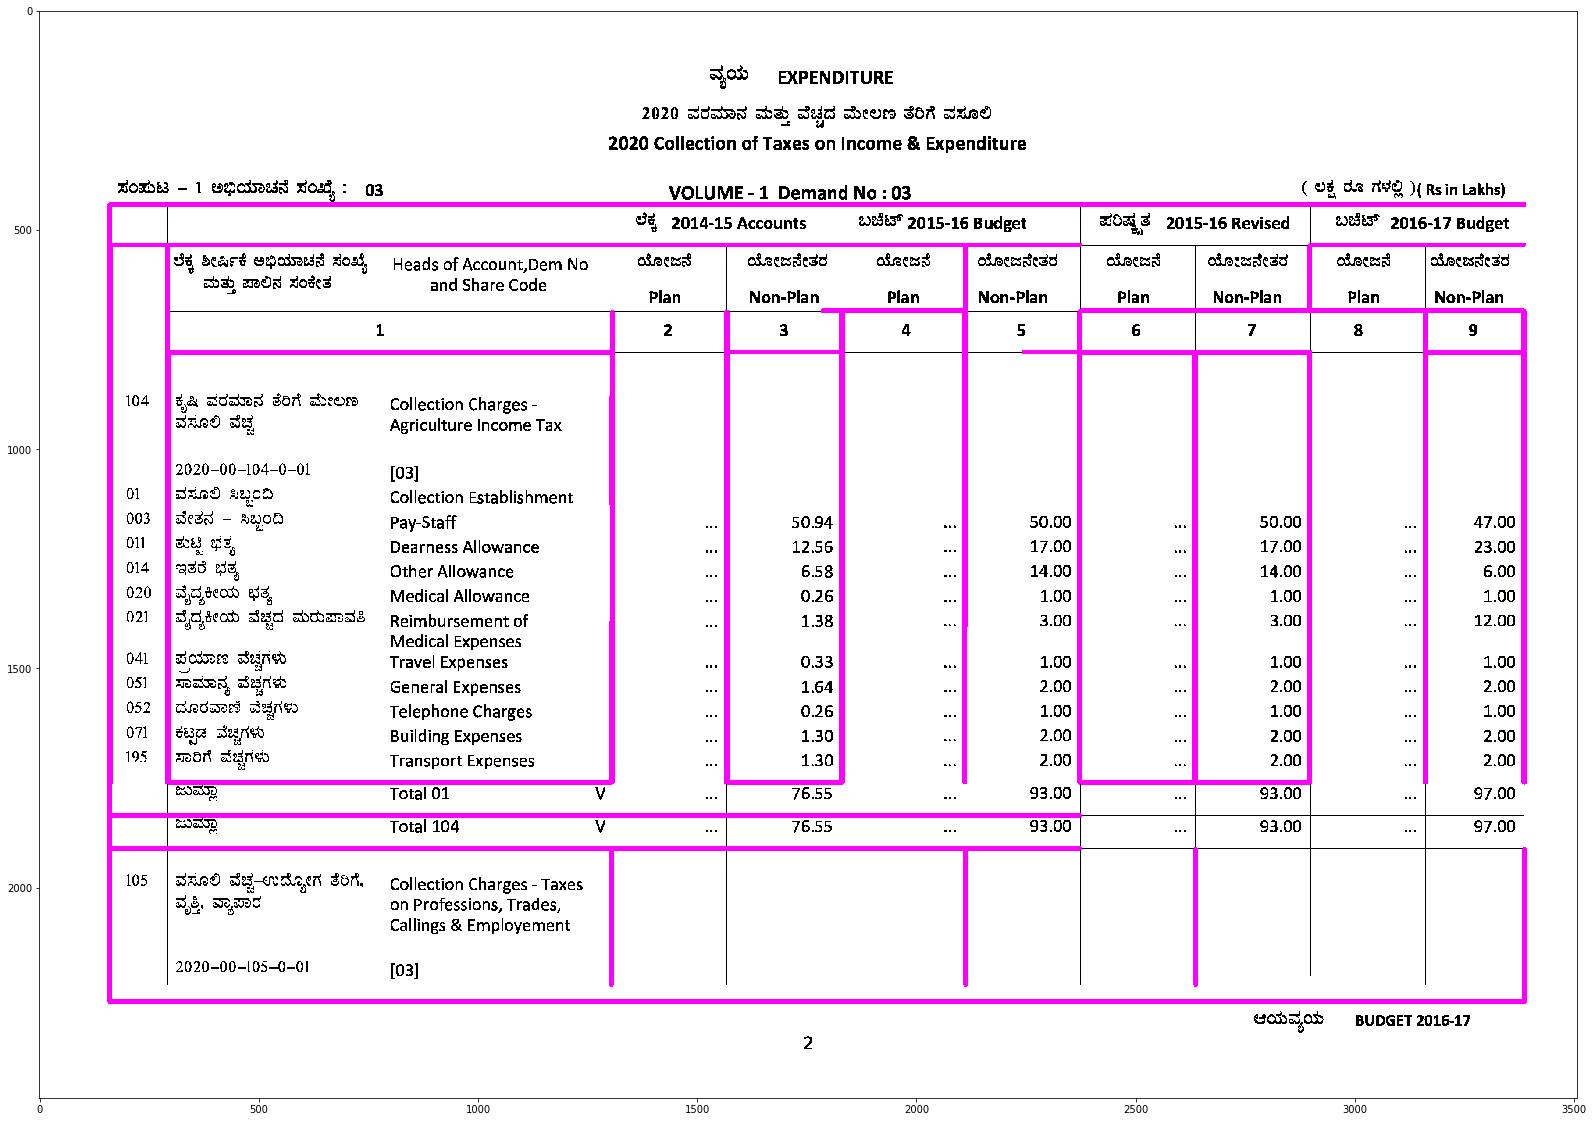

In [189]:
def get_straight_lines(img, aperture_size=3):                                                                                                         
    '''Extract long straight lines using Probabilistic Hough Transform
    '''
    edges = cv2.Canny(img, 120, 150, apertureSize=aperture_size)
    min_line_length = 100                                                                                                     
    max_line_gap = 100
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 80, min_line_length,
                            max_line_gap)
    return lines


lines = get_straight_lines(kn_page_image)
plot_lines_on_image(lines, kn_page_image)

In [190]:
BUFFER_LENGTH = 10
DEFAULT_PIXEL_COLOR = 255
PAGE_BREAK_HANDLE = '"||page_break||"'
DEFAULT_APERTURE_SIZE = 3

def get_horizontal_base_line(lines):
    '''Gives vertical coordinate of horizontal base line(aka header line) 
    '''
    horizontal_base_line = 0
    for line in lines:
        for x1, y1, x2, y2 in line:
            if y1 == y2 and (horizontal_base_line == 0 or horizontal_base_line > y1):
                horizontal_base_line = y1 + BUFFER_LENGTH
    return horizontal_base_line

def get_max_stretch(coordinate, stretch_vector):
    if stretch_vector[0] == stretch_vector[1] == 0:
        stretch_vector[0] = stretch_vector[1] = coordinate + BUFFER_LENGTH
    elif coordinate < stretch_vector[0]:
        stretch_vector[0] = coordinate - BUFFER_LENGTH
    elif coordinate > stretch_vector[1]:
        stretch_vector[1] = coordinate + BUFFER_LENGTH
    return stretch_vector

def get_table_limits(img, lines, is_header): 
    '''Get maximum horizontal and vertical line coordinates for bounding box
    '''
    table_limits = {}
    found_horizontal_line = False
    found_vertical_line = False
    vertical_stretch = [0,0]
    horizontal_stretch = [0,0]
    max_horizontal = [0,0,0,0]
    max_vertical = [0,0,0,0]
    horizontal_base_line = 0
    if is_header:
        horizontal_base_line = get_horizontal_base_line(lines)
    vertical_base_line = 0
    if type(lines).__module__ == "numpy":
        for line in lines:
            for x1,y1,x2,y2 in line:
                if x1 == x2:
                    if not found_vertical_line:
                        found_vertical_line = True
                    length = (y1 - y2)
                    if max_vertical[0] <= length:
                        max_vertical[0] = length
                        max_vertical[1] = y1 + BUFFER_LENGTH
                        max_vertical[2] = y2 - BUFFER_LENGTH
                    if (max_vertical[3] == 0 or max_vertical[3] > (x1 - BUFFER_LENGTH)) and (x1 - BUFFER_LENGTH) > vertical_base_line:
                        max_vertical[3] = (x1 - BUFFER_LENGTH)
                    horizontal_stretch = get_max_stretch(x1, horizontal_stretch)
                elif y1 == y2:
                    if not found_horizontal_line:
                        found_horizontal_line = True
                    length = (x2 - x1)
                    if max_horizontal[0] <= length:
                        max_horizontal[0] = length
                        max_horizontal[1] = x1 - BUFFER_LENGTH
                        max_horizontal[2] = x2 + BUFFER_LENGTH
                    if (max_horizontal[3] == 0 or max_horizontal[3] > (y1 - BUFFER_LENGTH)) and (y1 - BUFFER_LENGTH) > horizontal_base_line:
                        max_horizontal[3] = (y1 - BUFFER_LENGTH)
                    if not is_header:
                        vertical_stretch = get_max_stretch(y1, vertical_stretch)
    if max_vertical[2] > max_horizontal[3] and max_horizontal[3] > 0:
        max_vertical[2] = max_horizontal[3]
    if max_horizontal[1] >  max_vertical[3] and max_vertical[3] > 0:
        max_horizontal[1] = max_vertical[3]
    if (not found_vertical_line and found_horizontal_line) or not is_header:
        max_vertical[1:3] = vertical_stretch
    elif not found_horizontal_line and found_vertical_line:
        max_horizontal[1:3] = horizontal_stretch
    table_limits["horizontal"] = {"stretch": horizontal_stretch, "found": found_horizontal_line, "max": max_horizontal}
    table_limits["vertical"] = {"stretch": vertical_stretch, "found": found_vertical_line, "max": max_vertical}
    return table_limits


In [191]:
def extend_lines_for_table(img, lines, is_header, table_limits):
    ''' 
    Extend straight lines to create table bounds
    '''
    column_coordinates = []
    canvas = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2: 
                y1 = table_limits["vertical"]["max"][1]
                y2 = table_limits["vertical"]["max"][2]
                column_coordinates.append(x1)
            elif y1 == y2: 
                x1 = table_limits["horizontal"]["max"][1]
                x2 = table_limits["horizontal"]["max"][2]
            cv2.line(canvas, (x1, y1), (x2, y2), (255,0,255), 10)
    cv2.line(canvas,
             (table_limits["horizontal"]["max"][2],
              table_limits["vertical"]["max"][1]),
             (table_limits["horizontal"]["max"][2],
              table_limits["vertical"]["max"][2]),
             (255,0,255), 10)
    cv2.line(canvas,
             (table_limits["horizontal"]["max"][1],
              table_limits["vertical"]["max"][1]),
             (table_limits["horizontal"]["max"][1],
              table_limits["vertical"]["max"][2]),
             (255,0,255), 10)
    return canvas


## Extending Lines To Table Boundaries

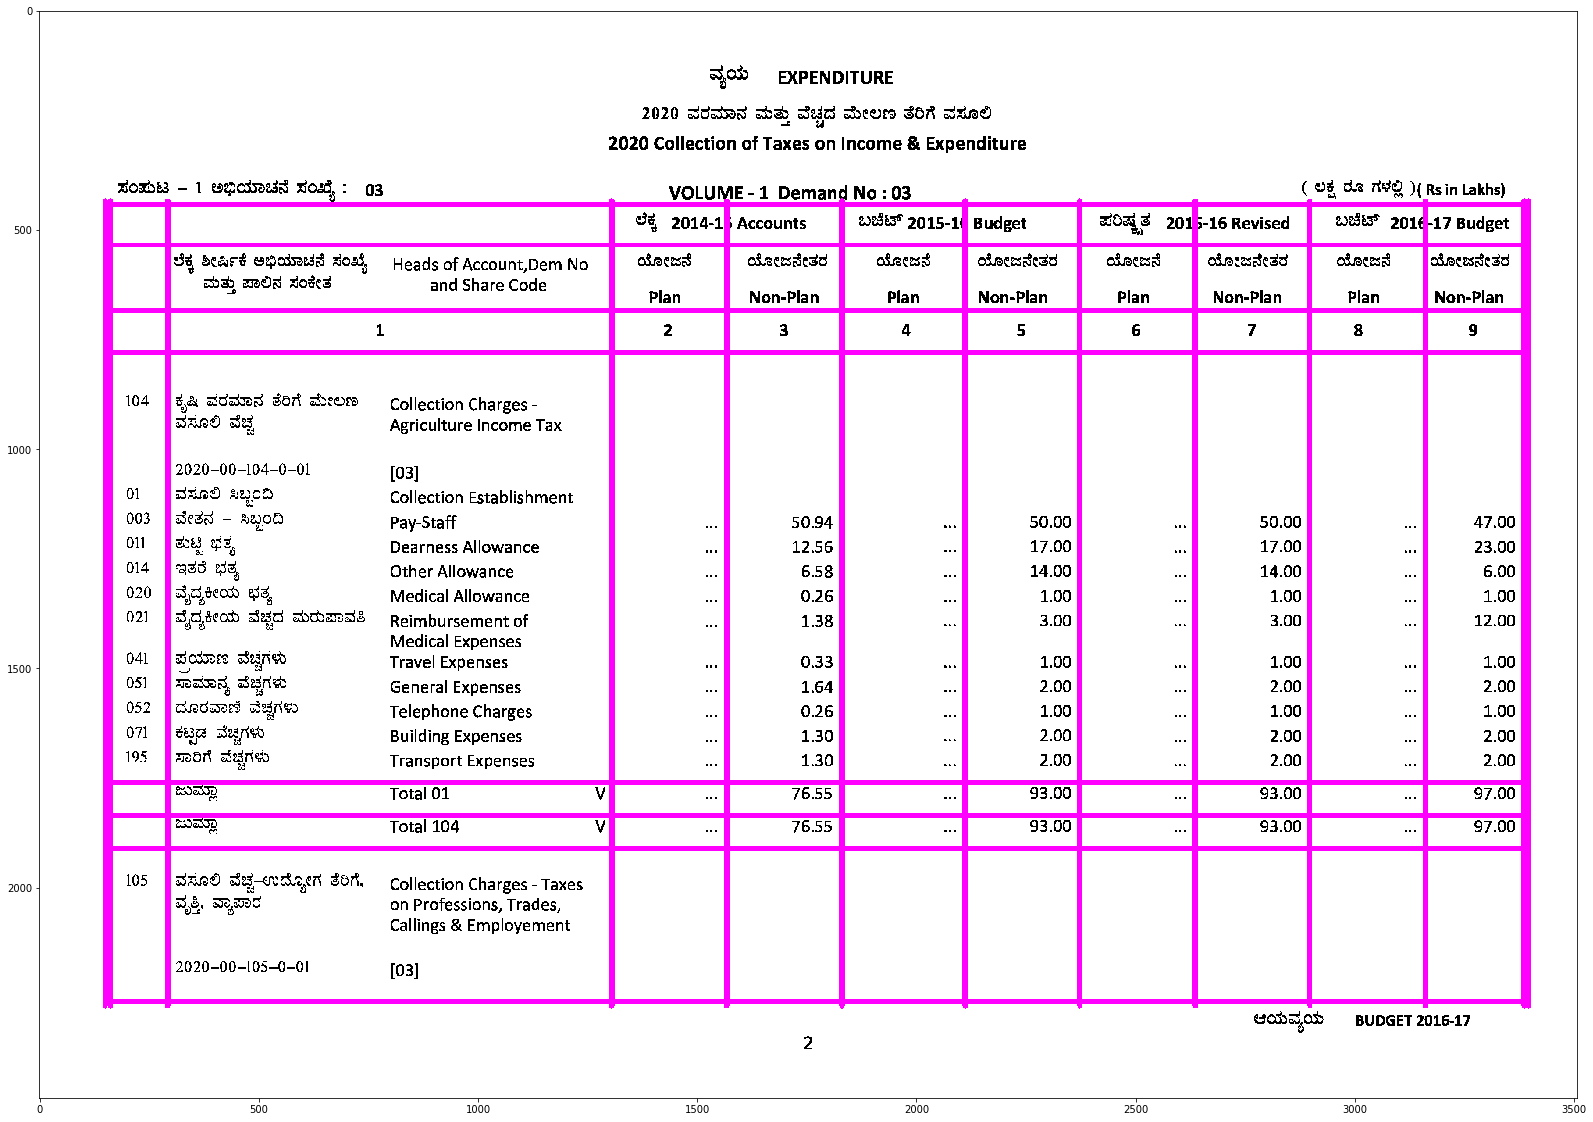

In [192]:
table_limits = get_table_limits(kn_page_image, lines, False)
plot_page(extend_lines_for_table(kn_page_image, lines, False, table_limits))

## Parsing PDF

tabula --pages 4 --area top,left,bottom,right --columns c1,c2,c3,c4 path/to/pdf


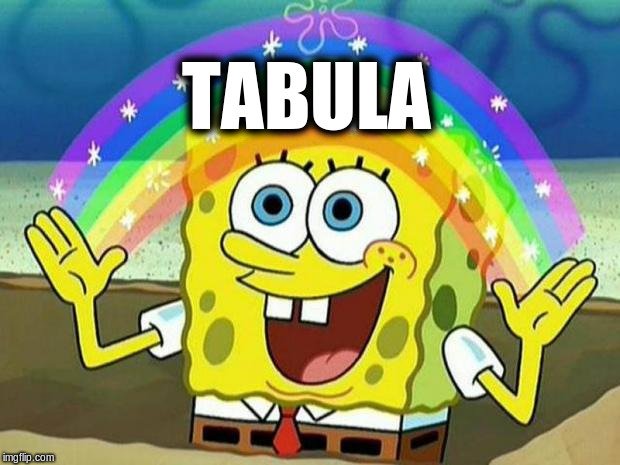

In [193]:
print("tabula --pages 4 --area top,left,bottom,right --columns c1,c2,c3,c4 path/to/pdf")
Image("spongebob.jpg")

Even though Tabula makes the job really easy for us, its not the silver bullet and it did not scale across different state budgets.

- There would be cases where tabula would merge 2 rows.
- Hough Transform couldn't detect lines without columnar lines present in the table, west bengal budget document.

## Extracting Table Without Boundaries 

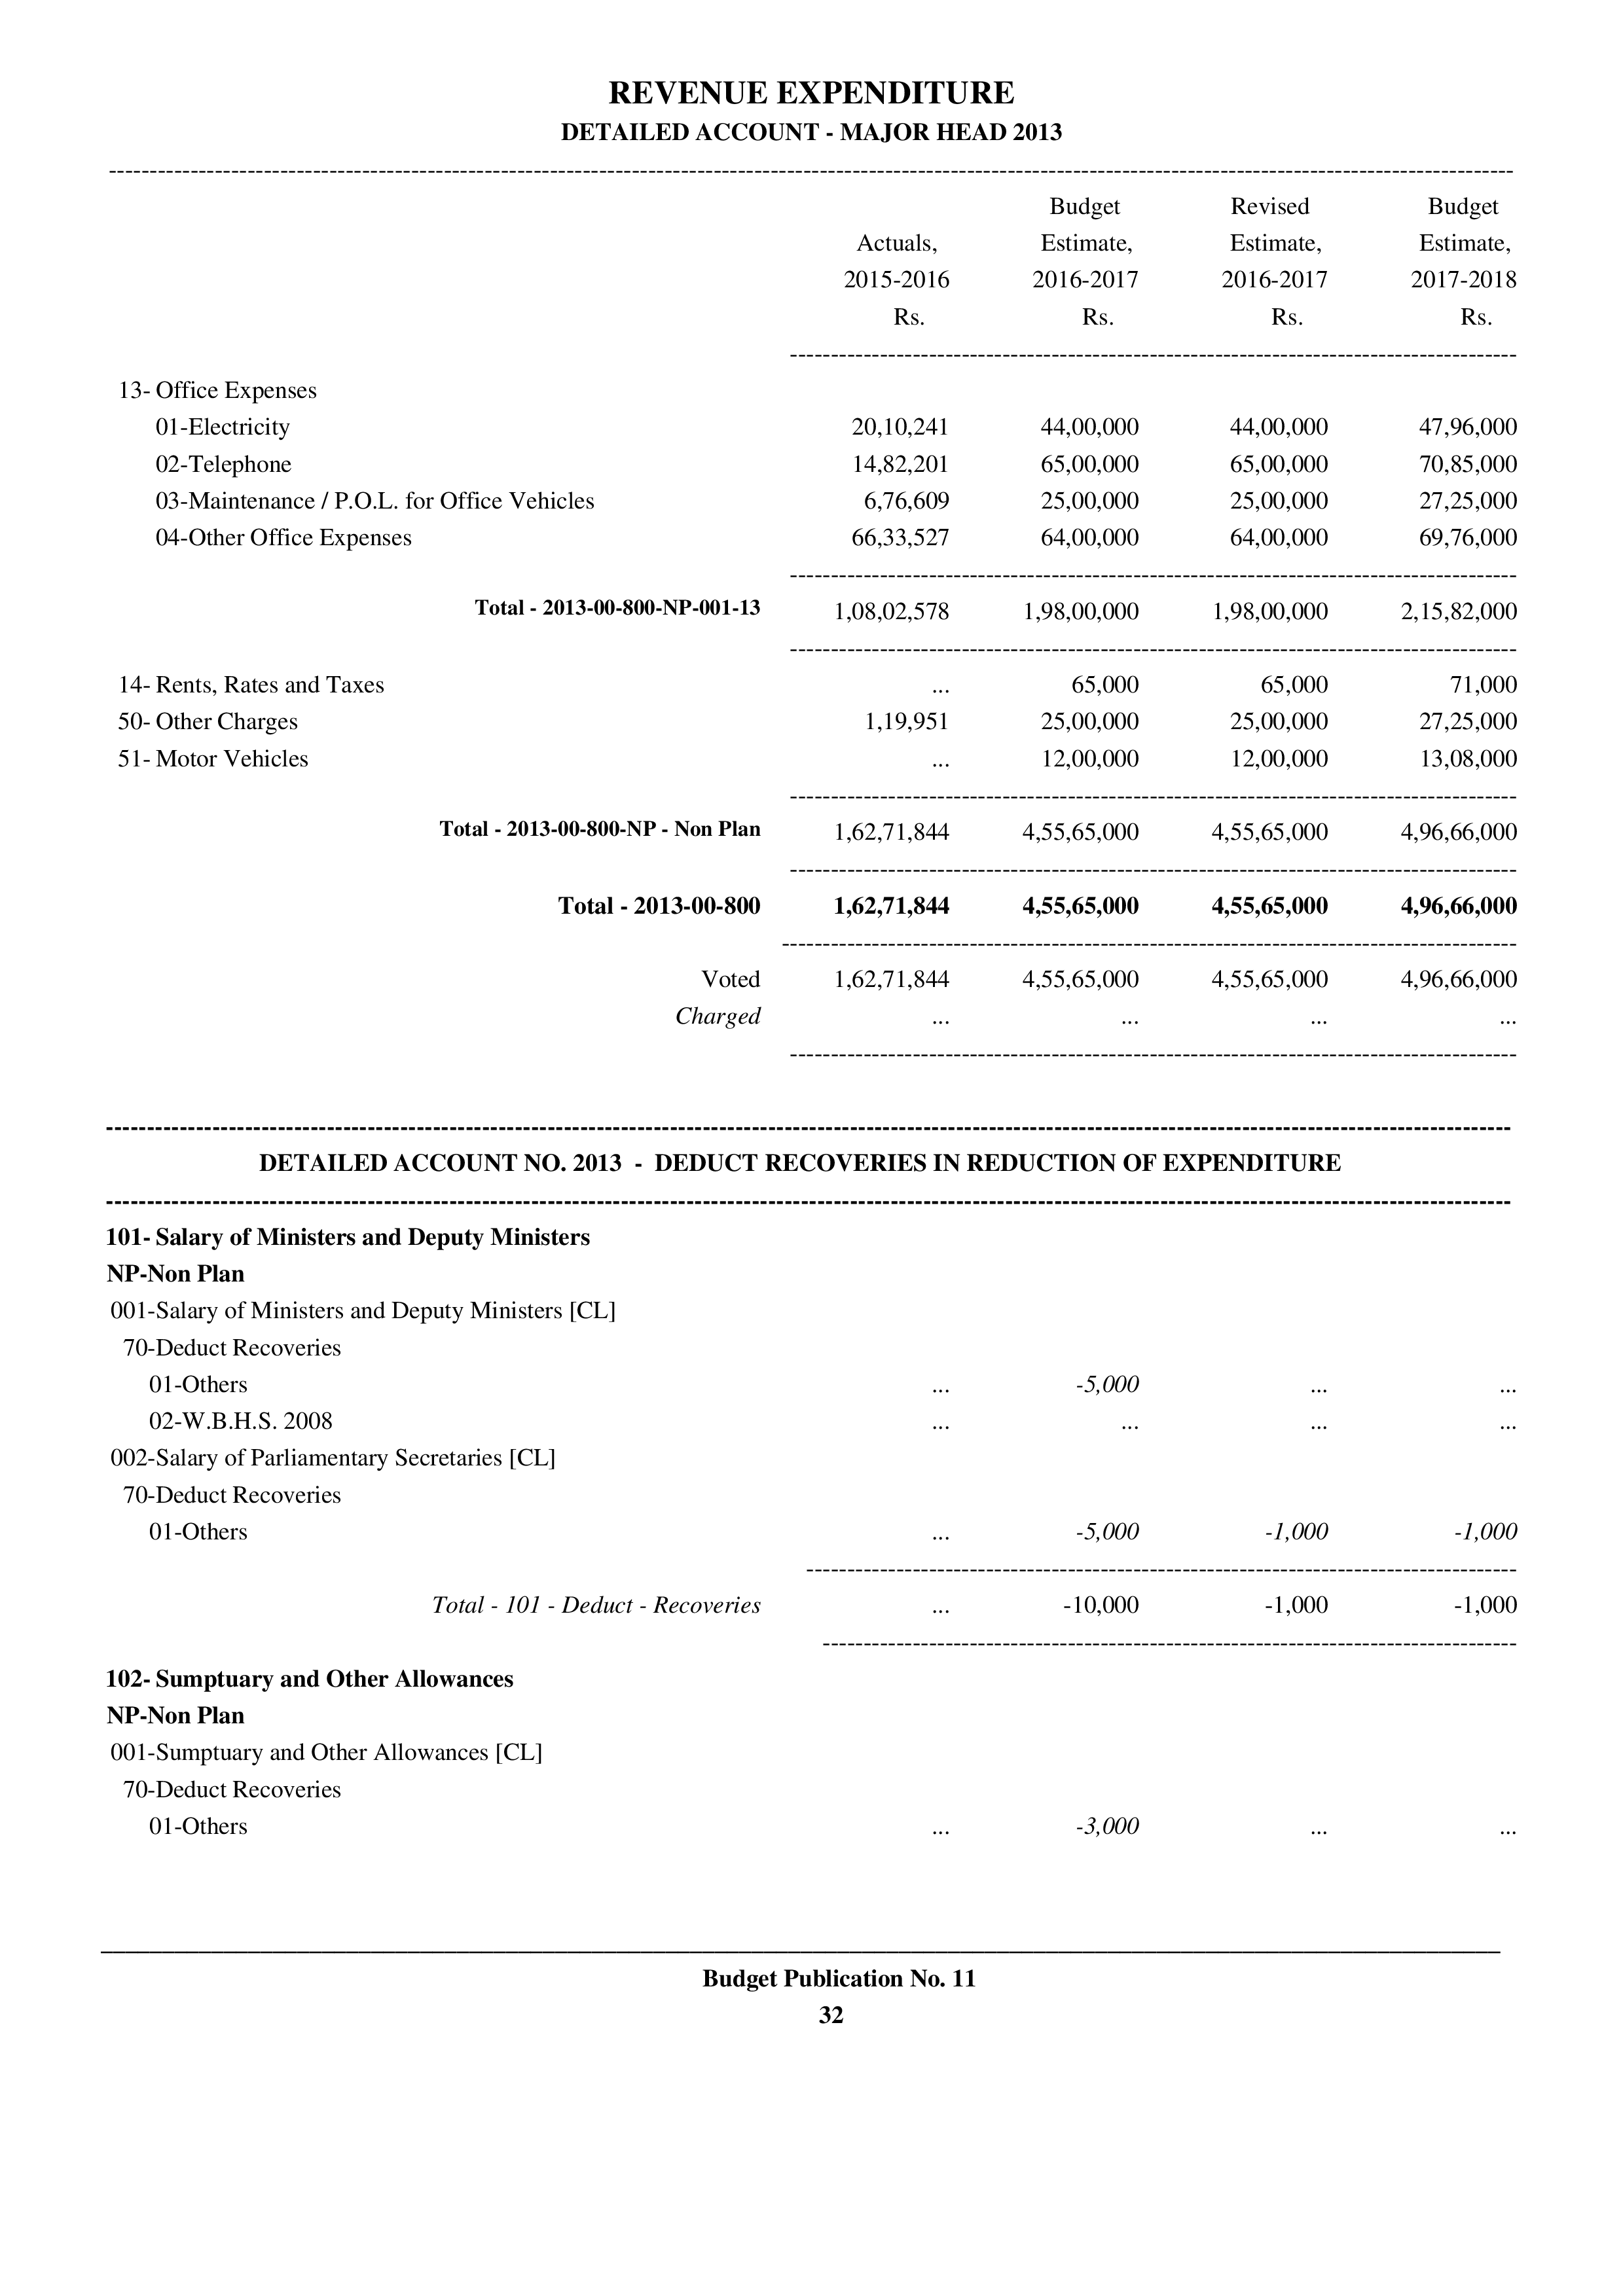

In [218]:
Image('west_bengal_sample.png')

## Exercise: Sample 1

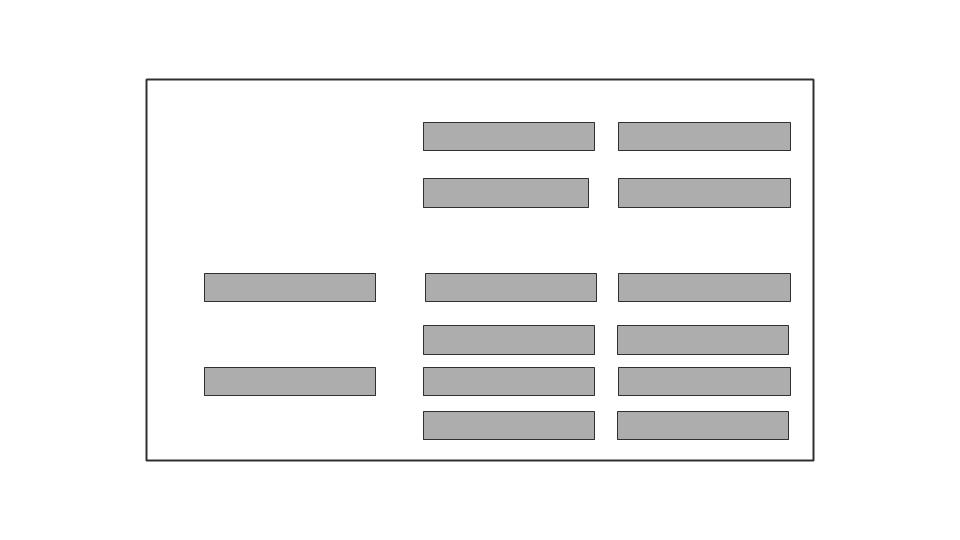

In [194]:
Image('subject2.jpg')

## Exercise: Sample 2

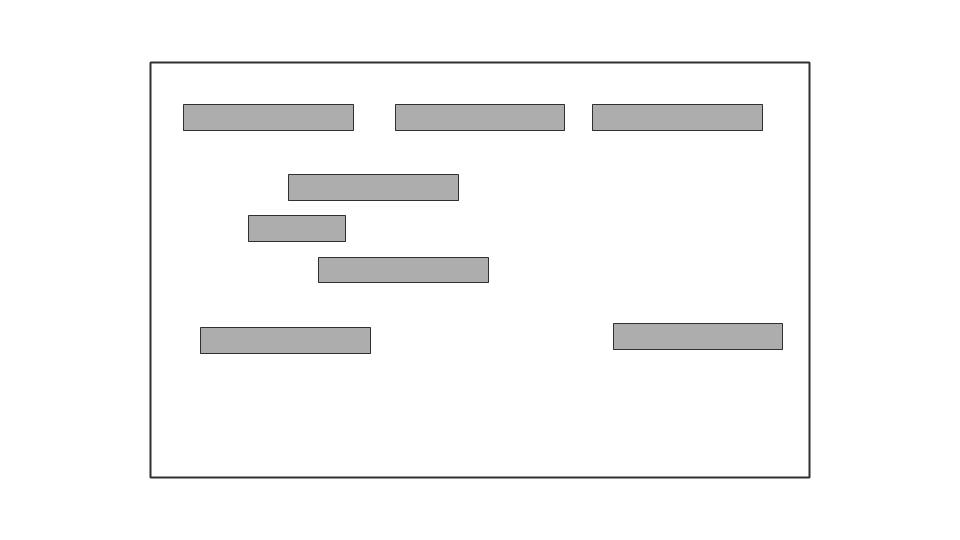

In [195]:
Image('subject1.jpg')

## Exercise: Sample 3

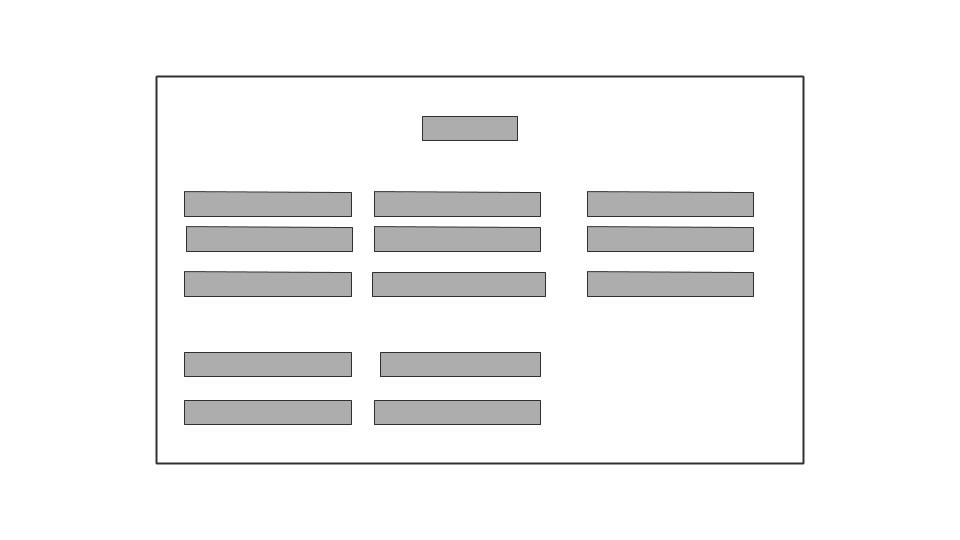

In [196]:
Image('subject3.jpg')

## Extracting Geometrical features

- Extract Blocks from Page Image.
- Extract geometrical features of each block.
    

## Extract Blocks From Page Image

    We use a modified version of the Run Length Smoothing Algorithm (RLSA)
    
    RLSA convert a byte sequence `x` into `y` based on two rules : -
    
    1. 0's in x are changed to 1 if their is 1 in the next C adjacent pixels.
    2. 1's remain unchanged.
    
    C here is a threshold


source: http://crblpocr.blogspot.in/2007/06/run-length-smoothing-algorithm-rlsa.html

## RLSA Image

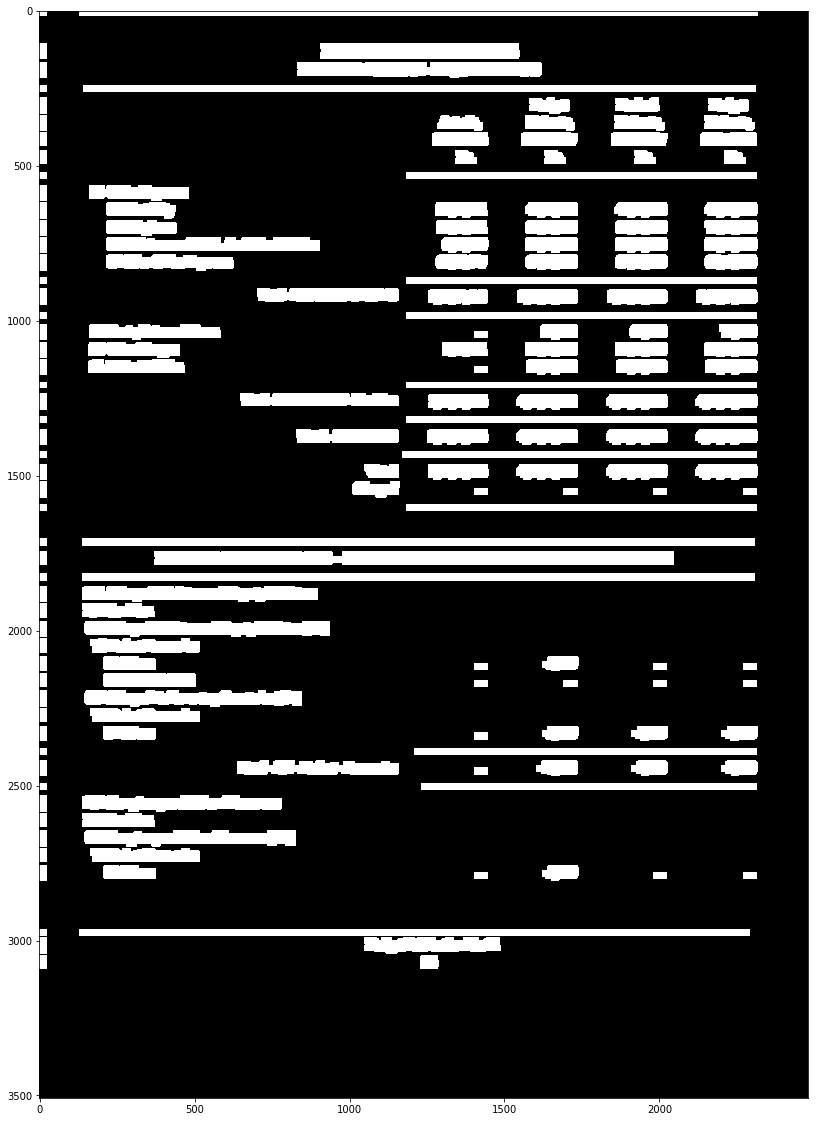

In [199]:
threshold = (25, 20)
wb_image_rlsa = rlsa_2d(wb_page_image, threshold)
plot_page(wb_image_rlsa)

## Can we do better ?

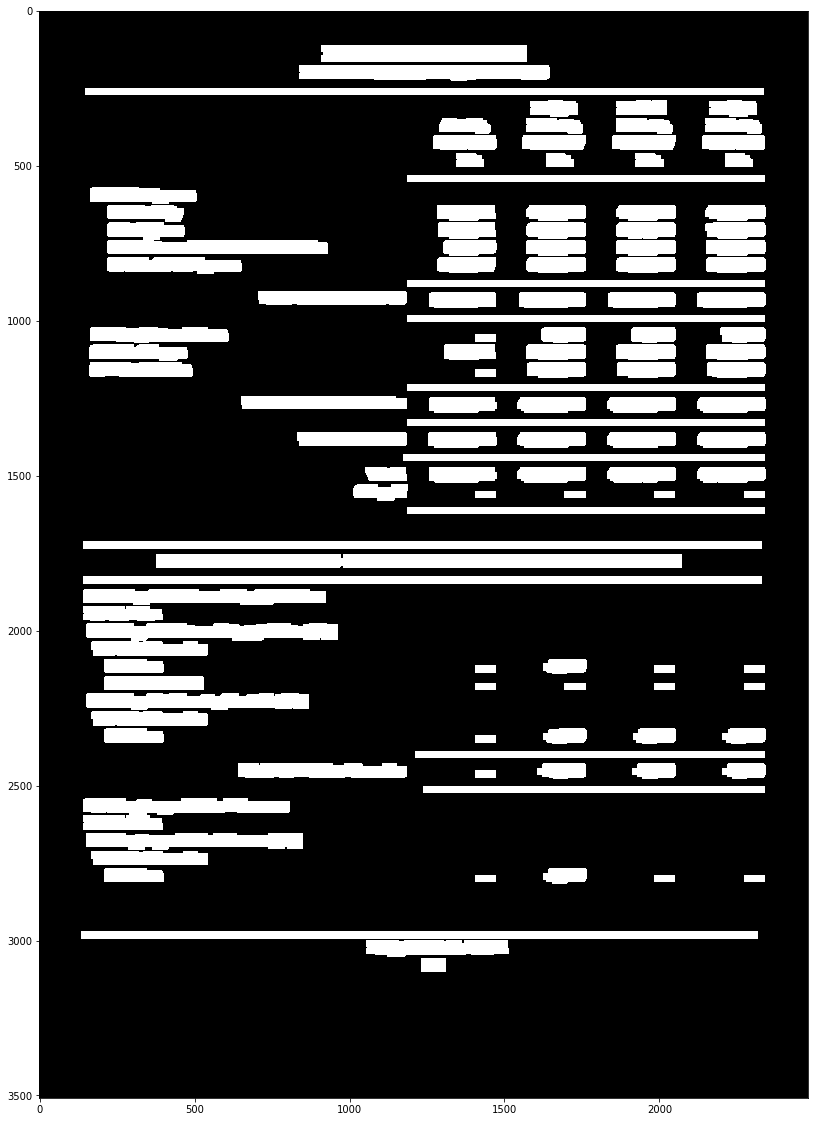

In [201]:
def generate_blocks_dilation(img):
    kernel = np.ones((5,10),np.uint8)
    ret,thresh1 = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV)
    return cv2.dilate(thresh1,kernel,iterations = 5)

plot_page(generate_blocks_dilation(wb_page_image))

## Extracting Features Using OpenCV

    Use cv2.connectedComponentsWithStats()

In [224]:
def get_block_stats(stats, centroids):
    '''
    Convert stats into a combined dataframe.
    '''
    stats_columns = ["left", "top", "width", "height", "area"]
    block_stats = pd.DataFrame(stats, columns=stats_columns)
    block_stats['centroid_x'], block_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
    # Ignore the label 0 since it is the background
    block_stats.drop(0, inplace=True)
    # Add right, bottom and position
    return block_stats

In [225]:
import pandas as pd

n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(wb_image_rlsa)

block_stats = get_block_stats(stats, centroids)
block_stats['right'] = block_stats.left + block_stats.width
block_stats['bottom'] = block_stats.top + block_stats.height
block_stats.head(10)

,left,top,width,height,area,centroid_x,centroid_y,right,bottom
1,0,0,25,20,500,12.000000,9.500000,25,20
2,130,0,2188,20,43760,1223.500000,9.500000,2318,20
3,0,105,25,54,1350,12.000000,131.500000,25,159
4,906,105,643,54,34128,1226.833304,131.129249,1549,159
5,0,169,25,49,1225,12.000000,193.000000,25,218
6,833,169,789,49,35613,1227.420240,191.262853,1622,218
7,0,242,25,22,550,12.000000,252.500000,25,264
8,143,242,2168,22,47696,1226.500000,252.500000,2311,264
9,0,282,25,54,1350,12.000000,308.500000,25,336
10,1579,282,133,54,5931,1644.686562,307.158827,1712,336


connected components with stats provide geometrical details about all the blocks that we generated using the modified rlsa

It provides :- 
    
    - number of components
    - labels
    - stats which include 
        - leftmost point
        - topmost point
        - height
        - width
        - area
    - centroid for each block.
    
and for convinience we can generate bottom and right.

## Layout Analysis

Identifying the layout of the table, where the elements of the table are :-

- Header
- Values
- Empty Cells

## Reading Text From PDF


    We use poppler's version of `pdftotext`

In [226]:
def get_text(page_num, pdf_file_name, x, y, w, h):
    command_text = 'pdftotext -enc UTF-8  -f {0} -l {0} -x {1} -y {2} -W {3} -H {4} "{5}" -'
    command = command_text.format(page_num + 1, int(x), 
                                  int(y), int(w),
                                  int(h), pdf_file_name)
    return subprocess.check_output(command, shell=True)

For each block we have shape attributes which we can use to extract text in those particular blocks and use the text to generate more features like

    - Is Number
    - Is text
    - Length of the characters etc

In [210]:
import re

In [211]:
def get_text_data(row, page_num, pdf_file_path, horizontal_ratio, vertical_ratio):
    x = (row['left'] * horizontal_ratio)
    y = (row['top'] * vertical_ratio)
    width = (row['width'] * horizontal_ratio) + 5
    hieght = (row['height'] * vertical_ratio) + 5
    text = get_text(page_num, pdf_file_path, x, y, width, hieght)
    if len(text.strip().replace('-','')) < 1:
        row['text'] = text.strip().replace('-','')
    else:
        row['text'] = text.strip()
    row['text_length'] = len(row['text'])
    row['possible_row_merger'] = '\n' in row['text']
    text_matched = re.findall('[a-zA-Z_]+', row['text'])
    comma_sep_matcher = re.compile('^[1-9].(,[0-9]).*$')
    if comma_sep_matcher.match(row['text'].replace('\n', ' ')):
        row['comma_separated_numbers_present'] = True
    else:
        row['comma_separated_numbers_present'] = False
    if len(text_matched) > 0:
        row['is_text'] = True
    else:
        row['is_text'] = False
        
    try:
        row['number'] = int(row['text'].replace(',',''))
    except:
        row['number'] = None
    return row

In [212]:
page_layout = wb_pdf.getPage(3)['/MediaBox']

if '/Rotate' in wb_pdf.getPage(3) and wb_pdf.getPage(3)['/Rotate'] == 90:
    page_width = float(page_layout[3])
    page_height = float(page_layout[2])
else:
    page_width = float(page_layout[2])
    page_height = float(page_layout[3])
image_height, image_width = wb_page_image.shape
horizontal_ratio = page_width / image_width
vertical_ratio = page_height / image_height

## Extracting Text based Features


In [229]:
text_columns = ['text', 'text_length', 'comma_separated_numbers_present', 'is_text', 'number']

In [230]:
block_stats = block_stats.apply(get_text_data, axis=1, args=[33, wb_pdf_file_path, horizontal_ratio, vertical_ratio])
block_stats[block_stats.text_length > 0][text_columns].sample(5)

,text,text_length,comma_separated_numbers_present,is_text,number
61,"1,98,00,000",11,False,False,19800000.0
83,...,3,False,False,NaN
91,"4,96,66,000",11,False,False,49666000.0
159,...,3,False,False,NaN
105,"4,55,65,000",11,False,False,45565000.0


## Rule Based Marking

- Mark Numbers
- Mark Headers
- Mark Titles
- Mark Groupings

Once we have this information it becomes easy to generate rules like 

 - comma separated values beyond a certain point are numbers
 - If Text with 70% percentage of blocks below it are numbers, its mostly a header
 - We can also detect Titles by their orientation and size, and all titles separate tables thus we get table numbers which helps us solve the problem of having multiple tables in a single sheet.
 - Text of the title also tells us in which category does the below numbers lie under.
 

In [231]:
def mark_number_cells(row):
    if (row['comma_separated_numbers_present'] and row['is_text'] is False) or (row['text'] == '...'):
        row['label'] = 'cell_values'
    return row


def mark_text_cells(row, labels):
    '''
    Detect cells below, left and right. Based on these cells make guesses of labels.
    '''
    left, right = row['left'], row['right']
    top, bottom = row['top'], row['bottom']
    if row['label'] != 'cell_values':      
        if (labels[(labels.right.between(right - 10, right + 10)) & 
                     (labels.top > top) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_header'
        elif (labels[(labels.top.between(top - 10, top + 10)) & 
                     (labels.left > left) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_grouping'
        elif (labels[(labels.bottom.between(bottom - 10, bottom + 10)) & 
                     (labels.left > left) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_grouping'
    return row

def cleanse_labels(labels):
    """
    We need to clean up labels to transform them into csv's
    
    1. Combine Headers so that they don't end up in new lines.
    2. Split label blocks with 2 values combined
    """
    processed_labels = pd.DataFrame()
    
    for index, row in labels.iterrows():
        splitted_row = []
        if row.possible_row_merger == True and  row.label != 'cell_header':
            for index, value in enumerate(row.text.split('\n')):
                new_row = {}
                for col in row.index:
                    new_row[col] = row[col]
                new_height = row.height // len(row.text.split('\n'))
                new_row['height'] = new_height
                new_row['top'] = row.top + (index * new_height)
                new_row['bottom'] = new_row['top'] + new_height
                new_row['text'] = value
                new_row['possible_row_merger'] = False
                splitted_row.append(new_row)
            processed_labels = processed_labels.append(splitted_row)
        else:
            processed_labels = processed_labels.append(row)
    return combine_horizontal(find_common_headers(processed_labels))


def combine_headers(labels):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_labels = pd.DataFrame()
    skip_pos = []
    for index, row in labels.iterrows():
        if row['pos'] not in skip_pos:
            nearby_header = labels[(labels.left.between(row['left'] - row['width'], row['right'])) &
                                   (labels.pos != row['pos']) &
                                   (labels.label == 'cell_header') &
                                   (labels.table == row['table'])].sort_values('top', ascending=True)
            if len(nearby_header) > 0 and row['label'] == 'cell_header':
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' ' + ' '.join(nearby_header.text.tolist())
                row['text'] = row['text'].replace('\n', ' ')
                row['width'] = row['width'] + nearby_header.width.sum()
                row['height'] = row['height'] + nearby_header.height.sum()
                row['left'] = min(row['left'], nearby_header.left.min())
                row['right'] = row['left'] + row['width']
                row['bottom'] = row['top'] + row['height']
                skip_pos.extend(nearby_header.pos.tolist())
            processed_labels = processed_labels.append(row)
    return processed_labels

def combine_horizontal(labels):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_labels = pd.DataFrame()
    skip_pos = []
    for index, row in labels.iterrows():
        if row['pos'] not in skip_pos:
            nearby_labels = labels[(labels.left.between(row['left'] - 5, row['right'] + 5)) &
                                   (labels.top.between(row['top'] -5, row['top'] + 5)) &
                                   (labels.pos != row['pos'])]
            if len(nearby_labels) > 0:
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' '.join(nearby_labels.text.tolist())
                row['width'] = row['width'] + nearby_labels.width.sum()
                row['right'] = row['left'] + row['width']
                skip_pos.extend(nearby_labels.pos.tolist())
            processed_labels = processed_labels.append(row)
    return processed_labels

def mark_titles(labels):
    labels.ix[((labels.is_text == True) & 
               (labels.centroid_x.between(1200, 1300)) &
               (pd.isnull(labels.label))
              ), 'label'] = 'title'
    return labels

def mark_summary(row):
    if row['is_text'] == True:
        summaries = re.findall("^[A-z, a-z]*\sRs. [0-9|,]*$", row['text'])
        if len(summaries) > 0:
            row['label'] = 'cell_summary'
    return row

def filter_out_footer(labels):
    bottom_boundary = labels[labels.label == 'cell_values']['bottom'].max()
    return labels[labels.top < bottom_boundary]

def mark_tables_using_titles(labels):
    titles = label_stats_with_text[label_stats_with_text.label == 'title']
    titles['next_diff'] = titles.top - titles.top.shift(1)
    seperators = titles[titles.next_diff > titles.next_diff.mean()]['top'].tolist()
    begin, end = labels.top.min(), labels.bottom.max()
    seperators = [begin] + seperators + [end]
    labels['table'] = None
    for index, sep in enumerate(seperators):
        if index > 0:
            table_start, table_end = seperators[index - 1], sep
            labels.loc[
                    labels['top'].between(table_start, table_end),
                    'table'
                ] = index
    return labels

def mark_rows(labels):
    for table in labels.table.unique():
        table_rows = labels[labels.table == table]
        rows = find_rows(table_rows)
        combined_rows = sorted(rows + table_rows[pd.isnull(table_rows.label)].bottom.unique().tolist())
        for index, row_start in enumerate(combined_rows[:-1]):
            row_end = combined_rows[index + 1]
            labels.loc[((labels.top.between(row_start, row_end)) & 
                        (labels.table == table)), 'row_index'] = index
    
    return labels
    
def find_common_headers(labels):
    unmarked_headers = labels[(labels.label == 'cell_header') & (pd.isnull(labels.header_index))]
    if len(unmarked_headers) > 0:
        header = unmarked_headers[unmarked_headers.top == unmarked_headers.top.min()]
        labels.ix[((labels.label == 'cell_header') & 
                   (labels.left.between(header.left.iloc[0] - header.width.iloc[0], header.right.iloc[0])) &
                   (pd.isnull(labels.header_index))
                  ), 'header_index'] = header.pos.iloc[0]
        return find_common_headers(labels)
    return labels

def mark_probable_headers(row, labels):
    left, top = row['left'], row['top']
    right, bottom = row['right'], row['bottom']
    labels = labels[labels.table == row['table']]
    # labels in a radius of 15
    x_pos_axis = labels[(labels.left.between(right - 10, right + 15)) &
                        (labels.label == 'cell_header')]
    x_neg_axis = labels[(labels.right.between(left - 15, left + 10)) &
                        (labels.label == 'cell_header')]
    y_pos_axis = labels[(labels.bottom.between(top - 20, top + 10)) &
                        (labels.label == 'cell_header')]
    y_neg_axis = labels[(labels.top.between(bottom - 10, bottom + 15)) &
                        (labels.label == 'cell_header')]

    if (len(x_pos_axis) + len(x_neg_axis) + len(y_pos_axis) + len(y_neg_axis)) > 0:
        if pd.isnull(row['label']):
            row['label'] = 'cell_header'
    return row

def find_higher_level_groupings(row, cell_grouping_height_range):
    bottom, label = row['bottom'], row['label']
    min_range, max_range = cell_grouping_height_range
    if (bottom > min_range) and (bottom < max_range) and (pd.isnull(label)):
        row['label'] = 'cell_higher_grouping'
    return row

In [232]:
# Mark All components as Text and Number
block_stats = block_stats[block_stats.text_length > 0].apply(mark_number_cells, axis=1)
block_stats = block_stats.apply(mark_text_cells, axis=1, args=[block_stats])
# Set some required columns that will be set later on.
block_stats['header_index'] = None
block_stats['pos'] = block_stats.index
# Clean up labels
block_stats = cleanse_labels(block_stats)
# Mark summaries, titles
# block_stats = mark_probable_headers(block_stats)
block_stats = mark_titles(block_stats)
block_stats = block_stats.apply(mark_summary, axis=1)
# Filter out excessive information
block_stats = filter_out_footer(block_stats)

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated [ipykernel_launcher.py:154]
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated [ipykernel_launcher.py:105]


In [233]:
block_stats[['text', 'label']].sample(10)

,text,label
137,02-W.B.H.S. 2008,cell_grouping
59,Total - 2013-00-800-NP-001-13,NaN
103,Voted,NaN
24,Rs.,NaN
52,"66,33,527",cell_values
68,"65,000",cell_values
134,...,cell_values
82,"13,08,000",cell_values
145,70-Deduct Recoveries,NaN
167,001-Sumptuary and Other Allowances [CL],NaN


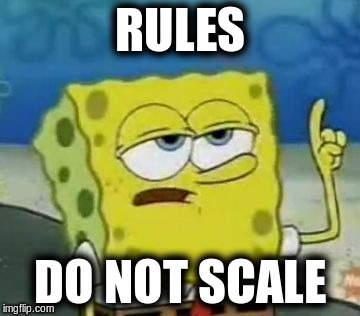

In [244]:
Image('rules.jpg')

## Moving from Rules to Machine Learning

### Generating Meta-Data via Logging

- Raw Images
- Blocked Images
- Features Generated
- Output

In [236]:
block_stats.head()

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,header_index,height,is_text,label,left,number,pos,possible_row_merger,right,text,text_length,top,width
4,34128.0,159.0,1226.833304,131.129249,0.0,NaN,54.0,1.0,title,906.0,NaN,4.0,0.0,1549.0,REVENUE EXPENDITURE,19.0,105.0,643.0
6,35613.0,218.0,1227.420240,191.262853,0.0,NaN,49.0,1.0,title,833.0,NaN,6.0,0.0,1622.0,DETAILED ACCOUNT - MAJOR HEAD 2013,34.0,169.0,789.0
10,5931.0,336.0,1644.686562,307.158827,0.0,NaN,54.0,1.0,NaN,1579.0,NaN,10.0,0.0,1712.0,Budget,6.0,282.0,133.0
11,6180.0,328.0,1927.556472,305.665210,0.0,NaN,46.0,1.0,NaN,1856.0,NaN,11.0,0.0,2001.0,Revised,7.0,282.0,145.0
12,5931.0,336.0,2222.686562,307.158827,0.0,NaN,54.0,1.0,NaN,2157.0,NaN,12.0,0.0,2290.0,Budget,6.0,282.0,133.0


## Opportunities

- Bayesian Models to predict labels for each block.
- Recurrent Neural Nets to mark blocks.

Source: https://twitter.com/fatiichi/status/466398802476548096


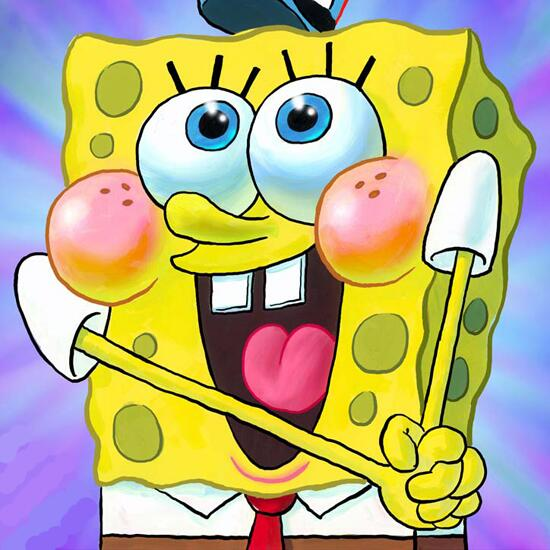

In [243]:
print('Source: https://twitter.com/fatiichi/status/466398802476548096')
Image('googly_eyes.jpg')

## Open By Default - Open Research

- Reproducable
- Understandable
- Collaborative

## Contribute

### Help us to:
- Generate more Open Budget Data
- Improve our Algorithms & Codebase
- Cover Budget Data in your Geography
- Refine our Designs & much more!

### We are open to new ideas, suggestions and feedback



# Open For Questions

# Thank You

## Github: https://github.com/cbgaindia


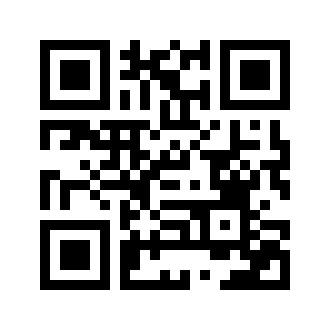

In [238]:
Image('static_qr_code_without_logo.jpg')